In [58]:
import os
import numpy as np
import gensim
import pandas as pd
import seaborn as sns
import ast
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from neurotools.language.simple_tokenizer import SimpleTokenizer
%matplotlib inline

# Other Brands

In this notebook, we consolidate the functions defined in the last notebooks and apply the same analysis done in volkswagen-3 for the other car brands.

In [2]:
# get list of all csv files for other car brands stored in separated_pl
files = ['separated_pl/' + x for x in os.listdir('separated_pl') if x.endswith('.csv')]
filenames = [x[x.find('/')+1: x.find('.csv')] for x in files]

In [3]:
emb = gensim.models.KeyedVectors.load_word2vec_format('data/pl_pl_commoncrawl_v3.bin', binary=True, encoding='utf-8', unicode_errors='ignore')

In [4]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


# Function Definitions

In [5]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [6]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [7]:
def fix_labels(x):
    if not pd.isnull(x['en_label']):
        label = x['en_label']
    else:
        label = x['de_label']#re.sub(r'[^a-z]', '', x['en'].split()[0].lower()) + '_nan'
    return label

In [8]:
def preprocess_dimensions():
    dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'de_label', 'pl', 'en']]
    dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
    dimensions['pl_no_nie'] = dimensions['pl'].map(lambda words: tokenizer.tokenize(' '.join([word for word in words.split() if not word.startswith('nie')])))
    dimensions['dimension'] = dimensions['pl_no_nie'].map(lambda x: get_average_vector(x, emb))
    dimensions['label'] = dimensions.apply(fix_labels, axis=1)
    return dimensions

In [77]:
def preprocess_csv(csv_file, with_nie = False):
    """
        Preprocess Facebook data to return only text and success metric. Optional flag if whether to include
        words with nie or not
    """
    pl = pd.read_csv(csv_file, encoding='cp1250')
    pl = pl.groupby('Post_text').head(1).reset_index().drop(columns = 'index')
    pl = pl[~pl["Post_text"].isnull()].reset_index()
    if not with_nie:
        pl['Post_text'] = pl['Post_text'].str.lower().str.split().map(lambda x: tokenizer.tokenize(' '.join([word for word in x if not word.startswith('nie')])))
    pl['success'] = (1/8) * pl['Total_likes'] + pl['Total_comments'] + pl['Shares_count']
    pl = pl[['Post_text', 'success']]
    return pl

In [48]:
def get_av_pos_neg_similarity_with_dimension(x, emb, dim, with_neg = False):
    """
        Define features for token list x based on dimension dim
        
        Input:
            x : list of tokens
            emb : embedding model
            dim : average word vector of dimension
            with_neg : whether to include negative features
    """
    pos = []
    neg = []
    zero = []
    for word in x:
        try:
            sim = cosine_similarity(emb[word], dim)
            if sim > 0:
                pos.append(sim)
            elif sim < 0:
                neg.append(sim)
            else:
                zero.append(sim)
        except KeyError:
            continue
            
    total = 1.0 * len(pos + neg + zero)
    
    if len(pos) == 0:
        count_pos = np.nan
        mean_pos = np.nan
        peak_pos = np.nan
    else:
        count_pos = len(pos)/total
        mean_pos = np.array(pos).mean()
        peak_pos = max(pos)

    if len(neg) == 0:
        count_neg = np.nan
        mean_neg = np.nan
        peak_neg = np.nan
    else:
        count_neg = len(neg)/total
        mean_neg = np.array(neg).mean()
        peak_neg = min(neg)

    if len(zero) == 0:
        count_zero = np.nan
    else:
        count_zero = len(zero)/total
    
    if with_neg:
        return count_pos, mean_pos, peak_pos, count_neg, mean_neg, peak_neg, count_zero
    else:
        return count_pos, mean_pos, peak_pos

In [49]:
def get_similarity_features(pl, dimensions):
    """
        Add columns to pl for similarity features for each dimension (we retain only pos features)
    """
    labels = dimensions['label'].values
    for i in range(dimensions.shape[0]):
        pl['dim_{}'.format(labels[i])] = pl['Post_text'].map(lambda x: get_av_pos_neg_similarity_with_dimension(x, emb, dimensions['dimension'].iloc[i]))
        pl[['count_pos_{}'.format(labels[i]), 
          'mean_pos_{}'.format(labels[i]), 
          'peak_pos_{}'.format(labels[i])]] = pd.DataFrame(pl['dim_{}'.format(labels[i])].values.tolist())
    return pl

In [80]:
def get_label(string):
    """
        Convert feature names to 'more X association' labels
    """
    if string.find('neg') != -1:
        name = string[string.find('neg')+4:]
        label = 'less opposite {} associations'.format(name)
    elif string.find('pos') != -1:
        name = string[string.find('pos')+4:]
        label = 'more {} associations'.format(name)
    else:
        return string
    return label

In [100]:
def get_top_bot(pl, label):
    """
        Get the top 10 positive and negative correlations and plot these in bar charts.
        Also return a csv file of the pairwise correlations of the associations and 
        success metric.
    """
    corr_matrix = pl.corr()
    corr_success = corr_matrix['success']
    corr_success = corr_success[~pd.isnull(corr_success)].sort_values(ascending=False)
    upper = list(corr_success.iloc[1:11].index)
    lower = list(corr_success.iloc[-10:].index)
    dims_to_graph = upper + lower
    to_bar = corr_success.loc[dims_to_graph].sort_values(ascending=True)
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[:10], to_bar.values[:10], color='lightcoral')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[:10], [get_label(x) for x in np.array(to_bar.index)[:10]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/bot_{}_10.png'.format(label), bbox_inches='tight');
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[10:], to_bar.values[10:], color='limegreen')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[10:], [get_label(x) for x in np.array(to_bar.index)[10:]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/top_{}_10.png'.format(label), bbox_inches='tight');
    
    matrix_cols = ['success'] + dims_to_graph
    correlogram = corr_matrix.loc[matrix_cols, matrix_cols]
    correlogram.index = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.index]
    correlogram.columns = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.columns]
    correlogram.to_csv('data/brands/correlogram_{}.csv'.format(label))
    
    plt.figure(figsize=(16,12))
    sns.heatmap(correlogram)
    plt.title(label, size = 20)
    plt.xticks(size=15, rotation = 90);
    plt.yticks(size=15, rotation = 0);
    plt.savefig('fig/brands/correlogram_{}.png'.format(label), bbox_inches='tight');

# Run analysis on other files

In [101]:
dimensions = preprocess_dimensions()

/Users/piocalderon/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


doing hondapolska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


doing chevroletpl
doing bmw.polska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


doing seatpolska
doing skodapolska
doing fiatpl
doing ford.polska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


doing kiamotorspolska
doing mercedesbenzpolska
doing lexuspolska
doing landroverpolska
doing jaguarpolska
doing toyotapolska
doing ferrarikatowice
doing chryslerpolska
error encountered in chryslerpolska
doing audipl
doing porschepl
doing citroenpolska
doing volkswagenpolska
doing peugeotpolska
doing renaultpolska
doing hyundaipolska
doing jeeppl
doing opelklub


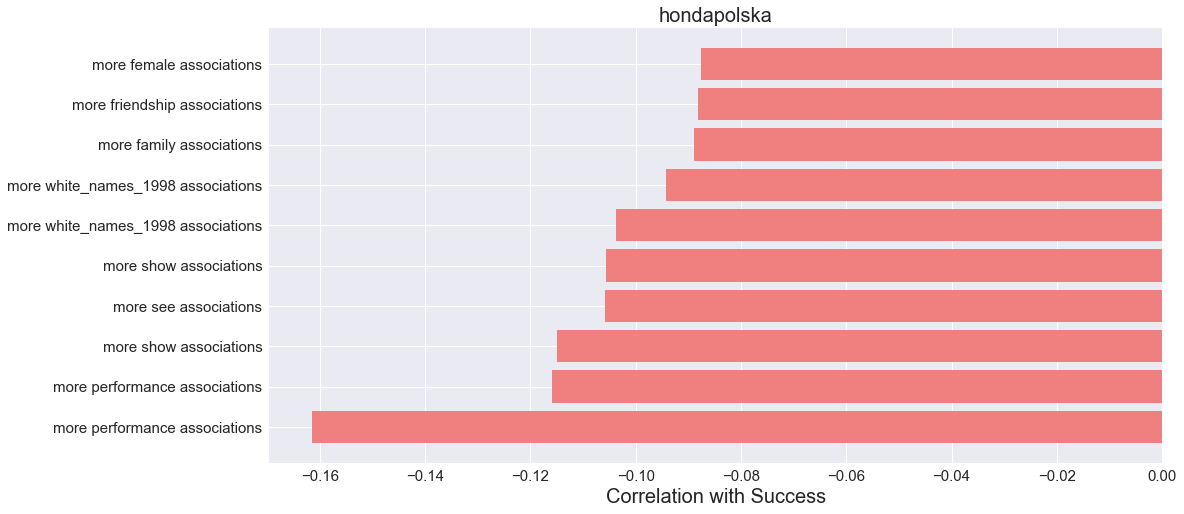

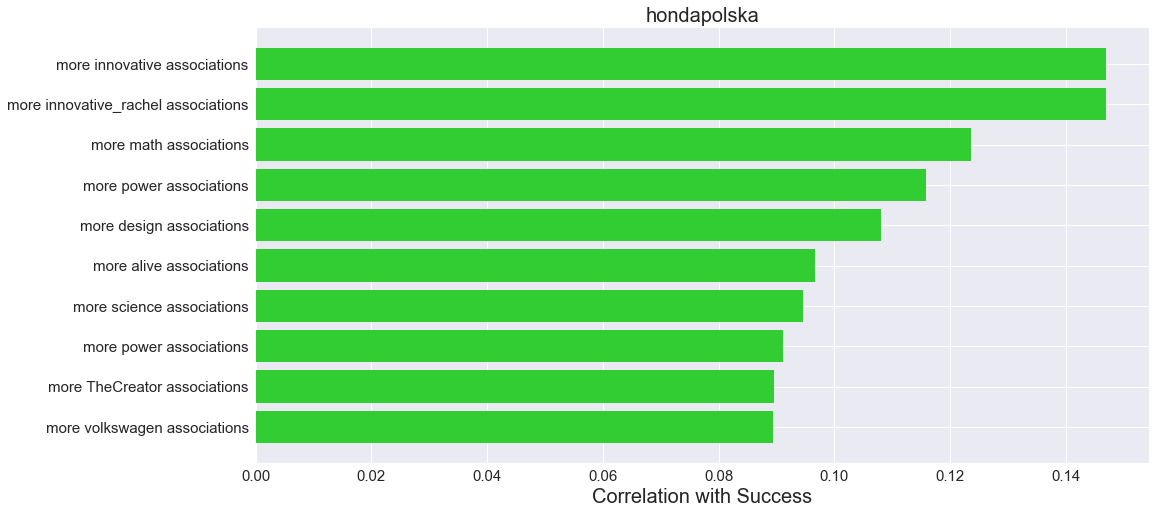

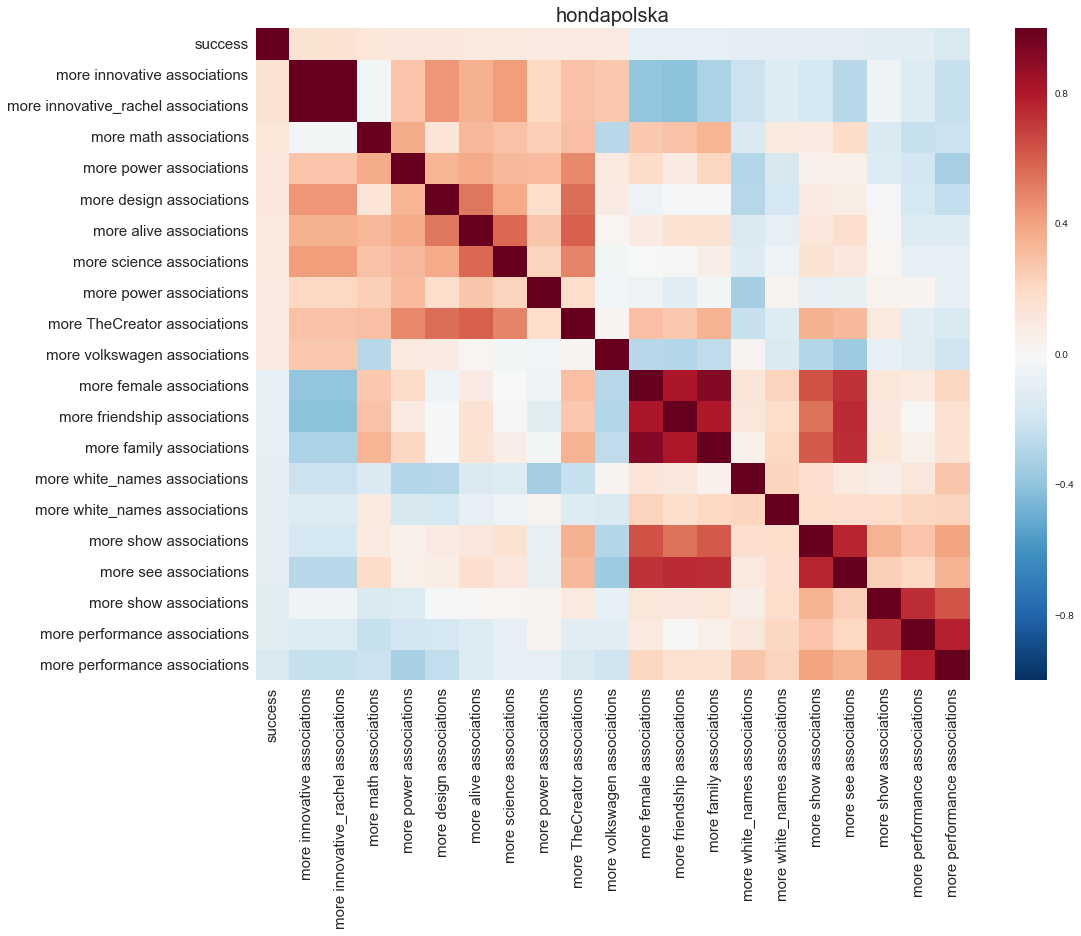

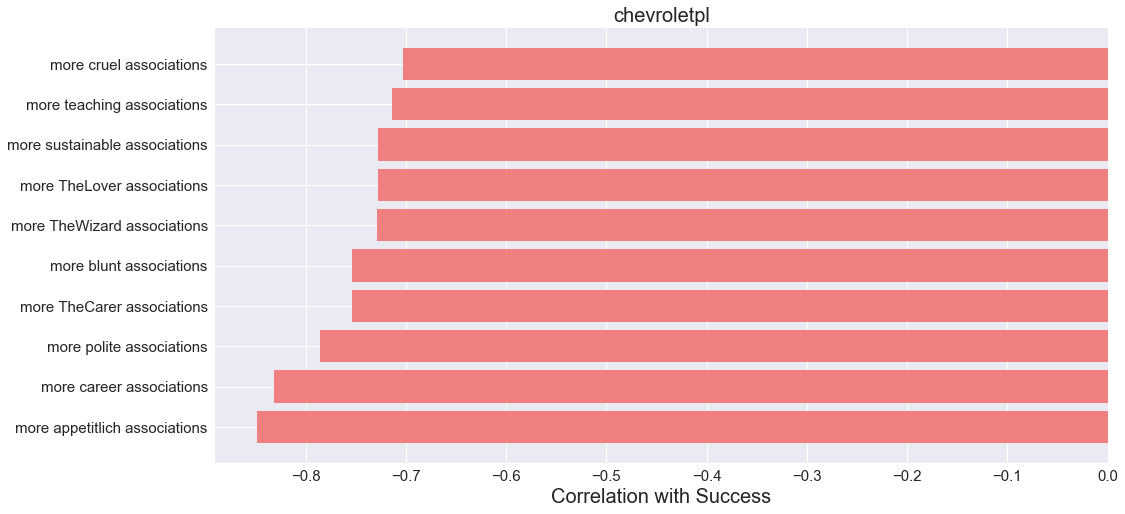

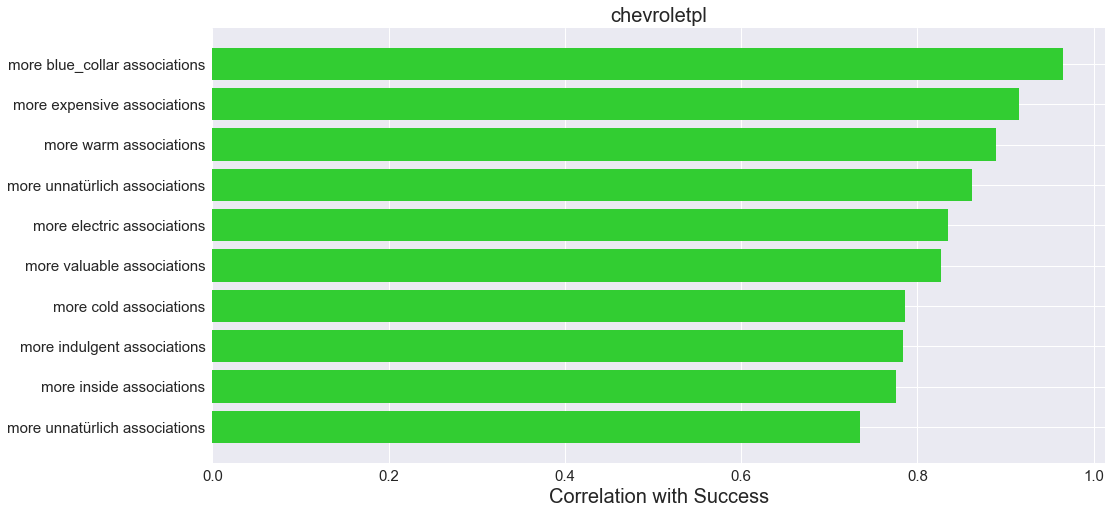

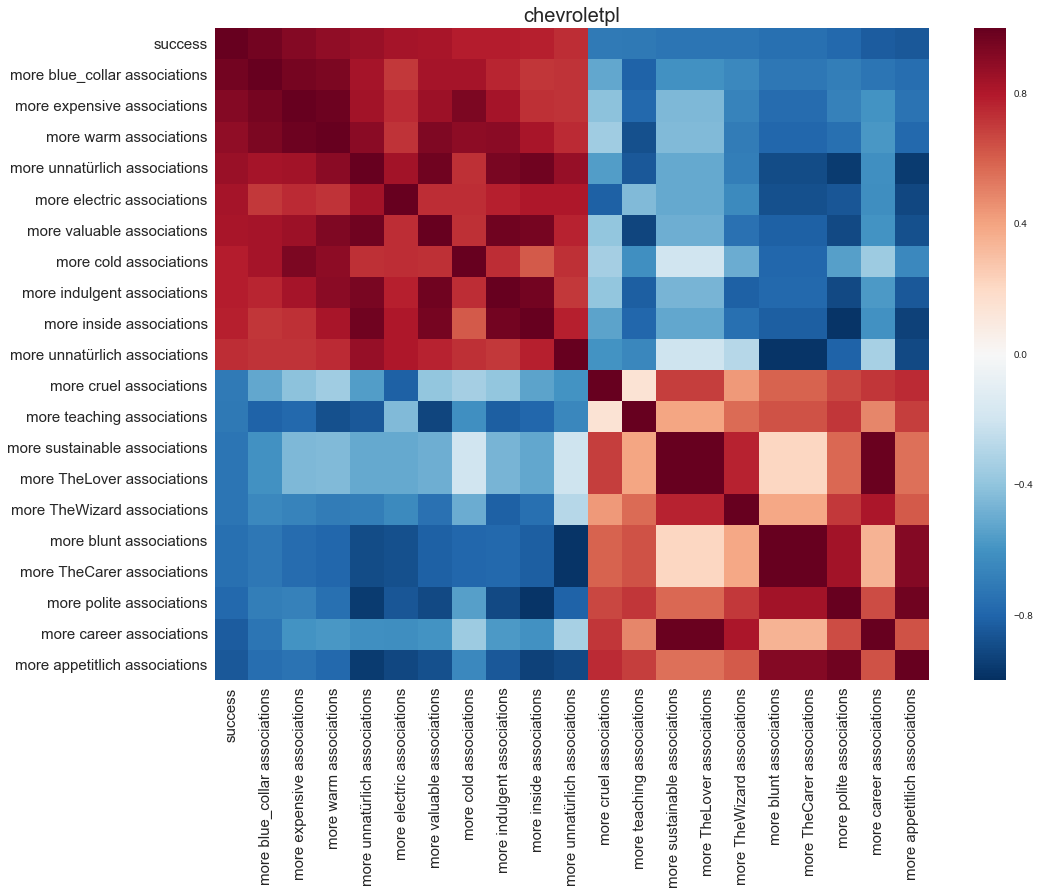

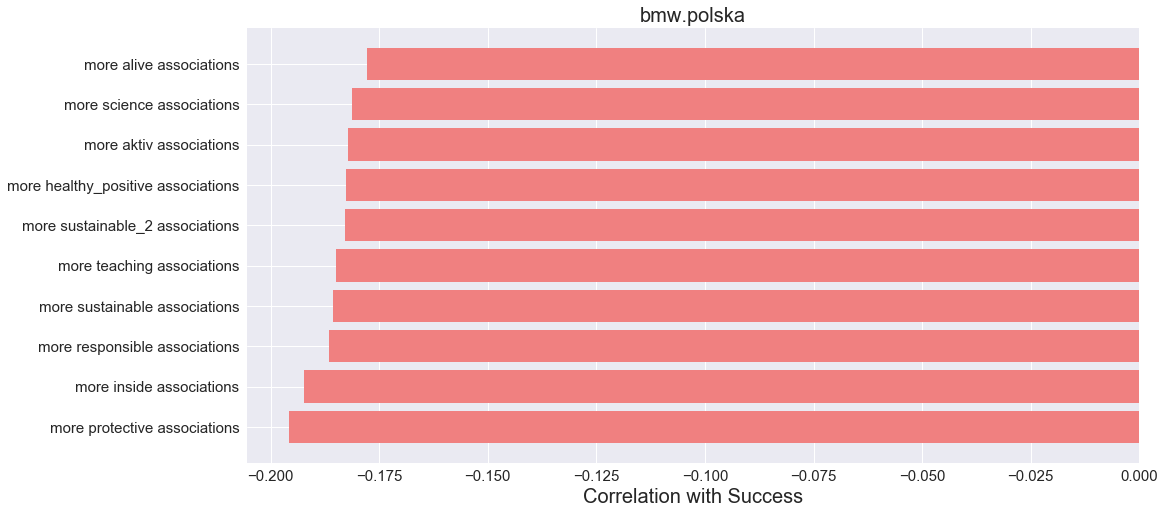

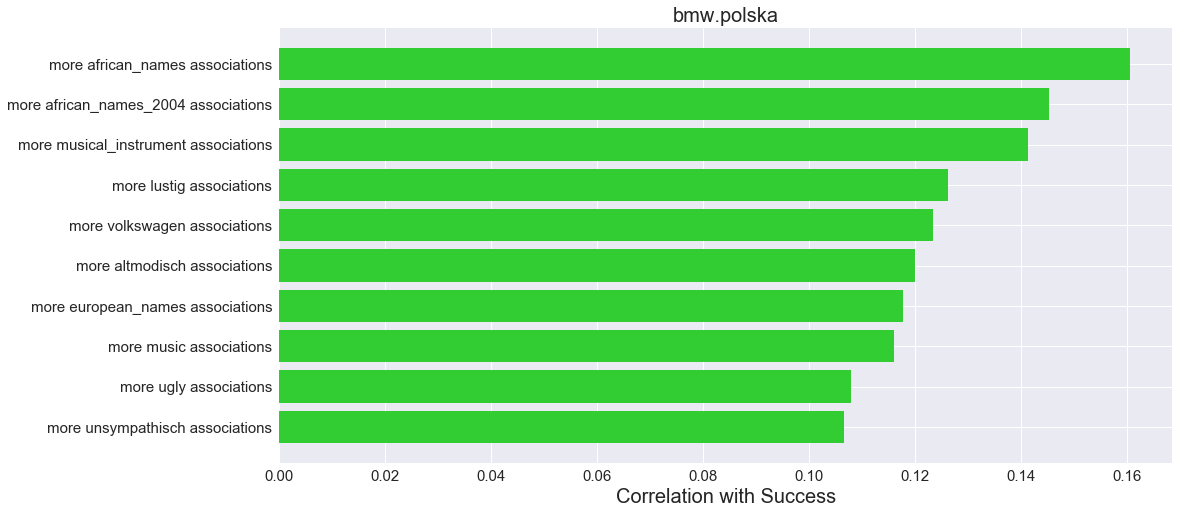

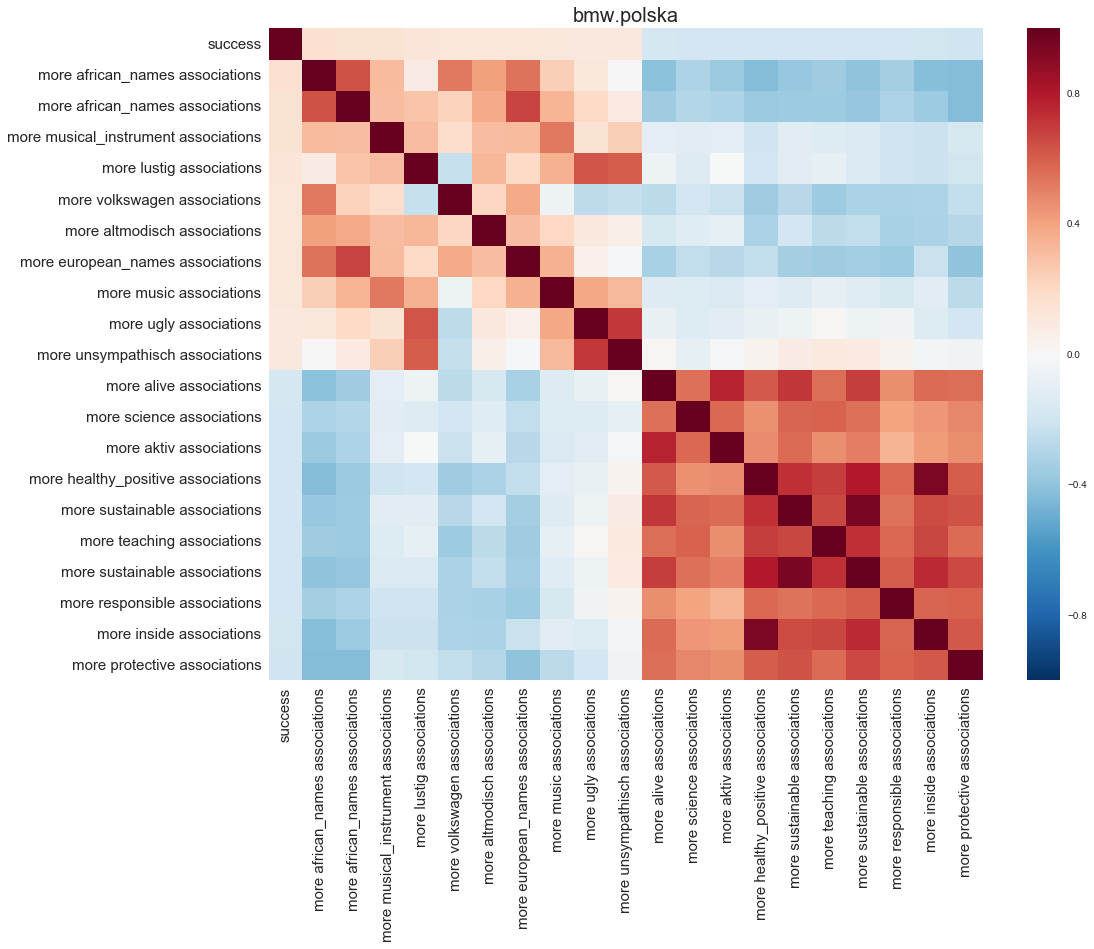

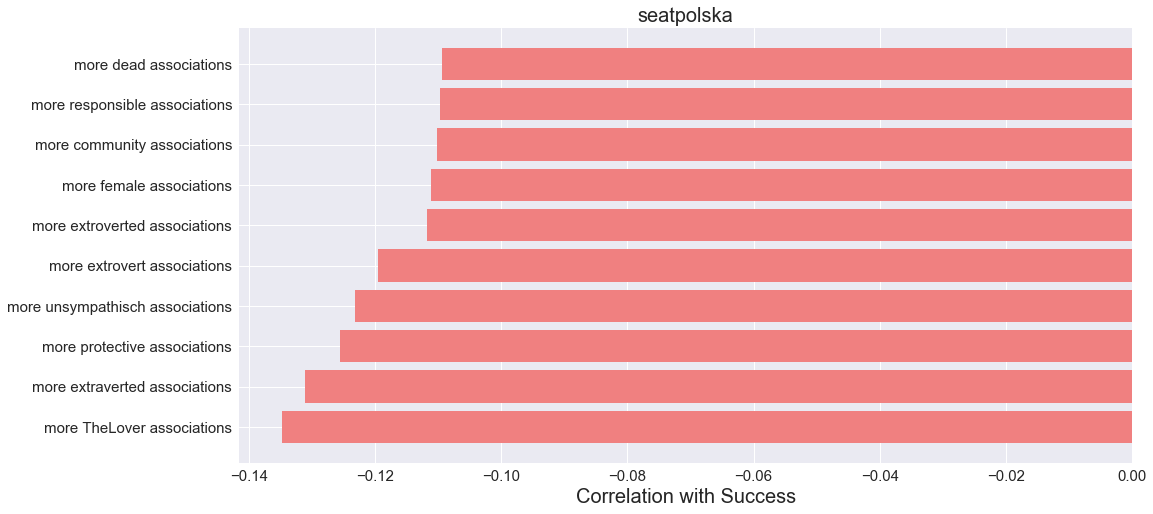

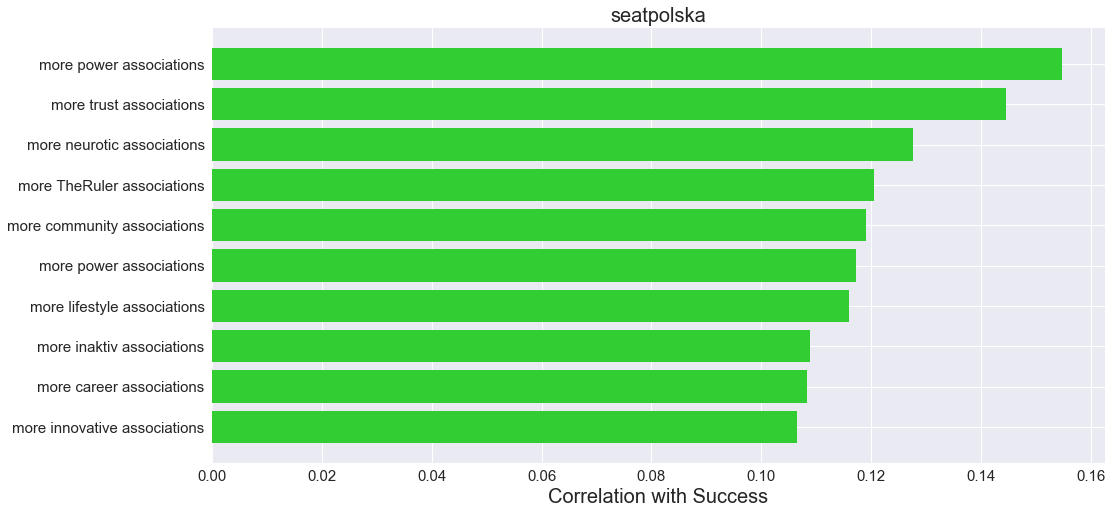

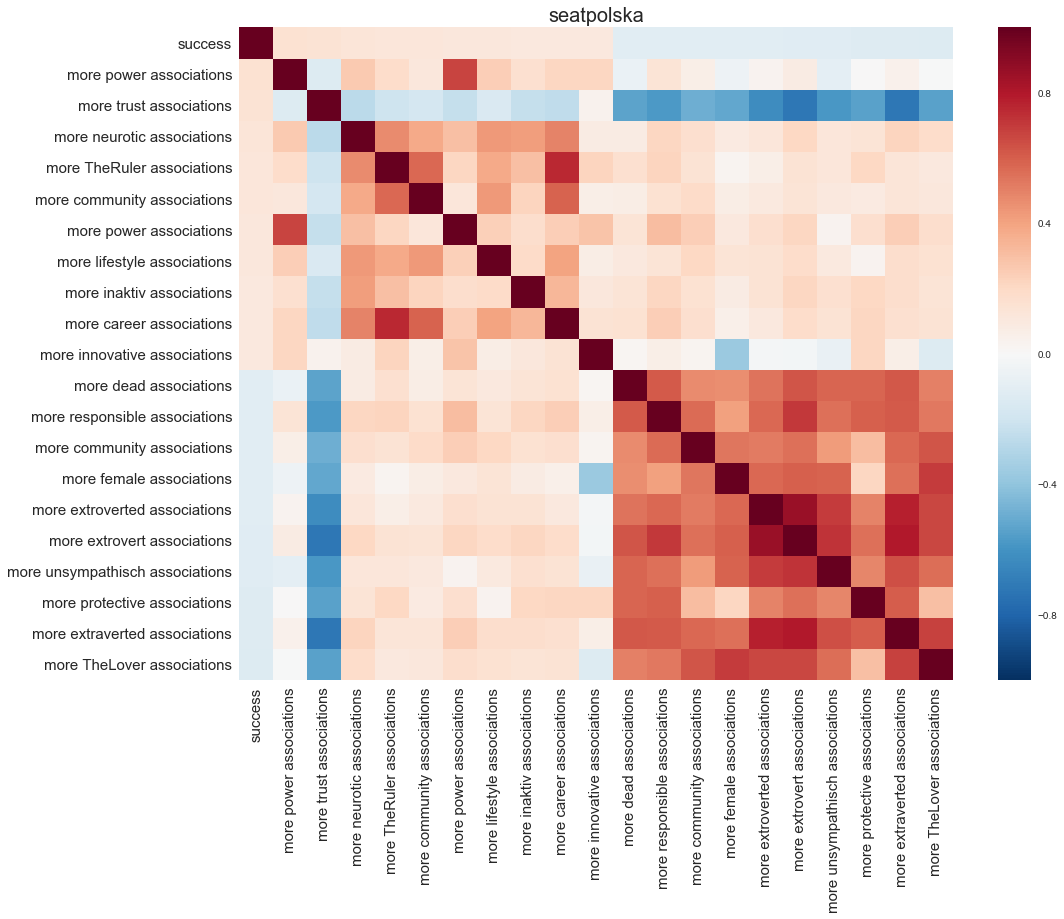

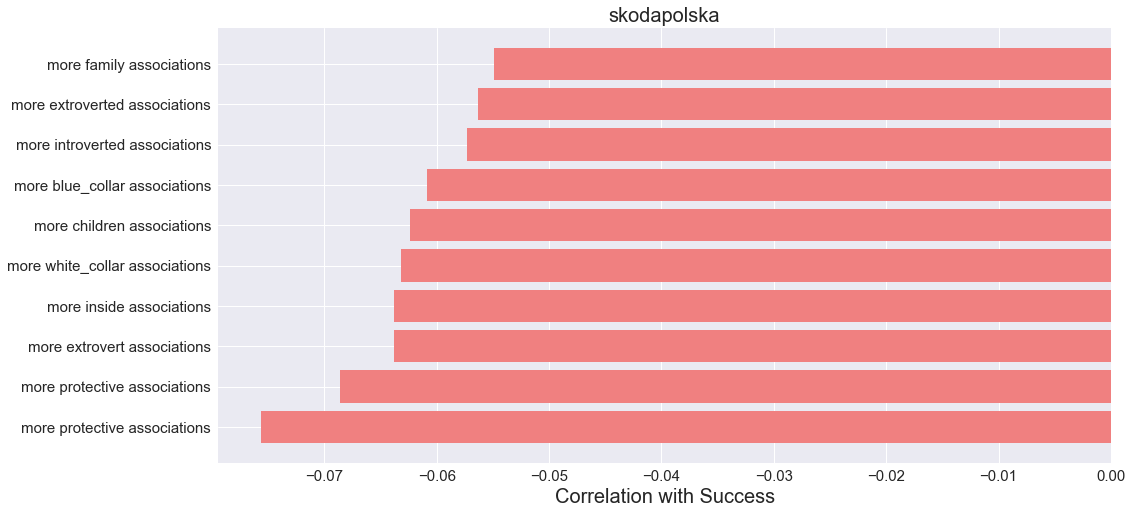

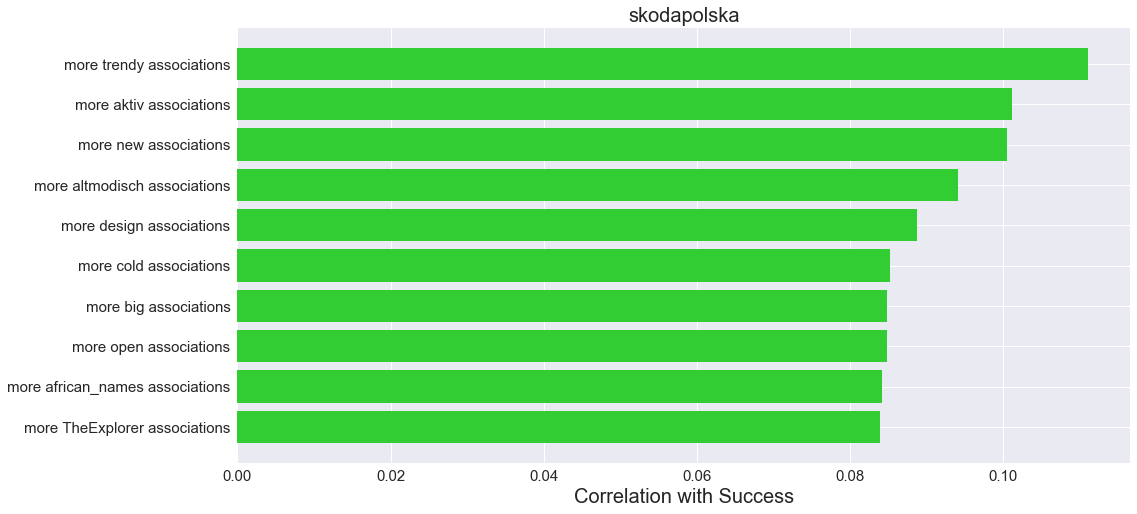

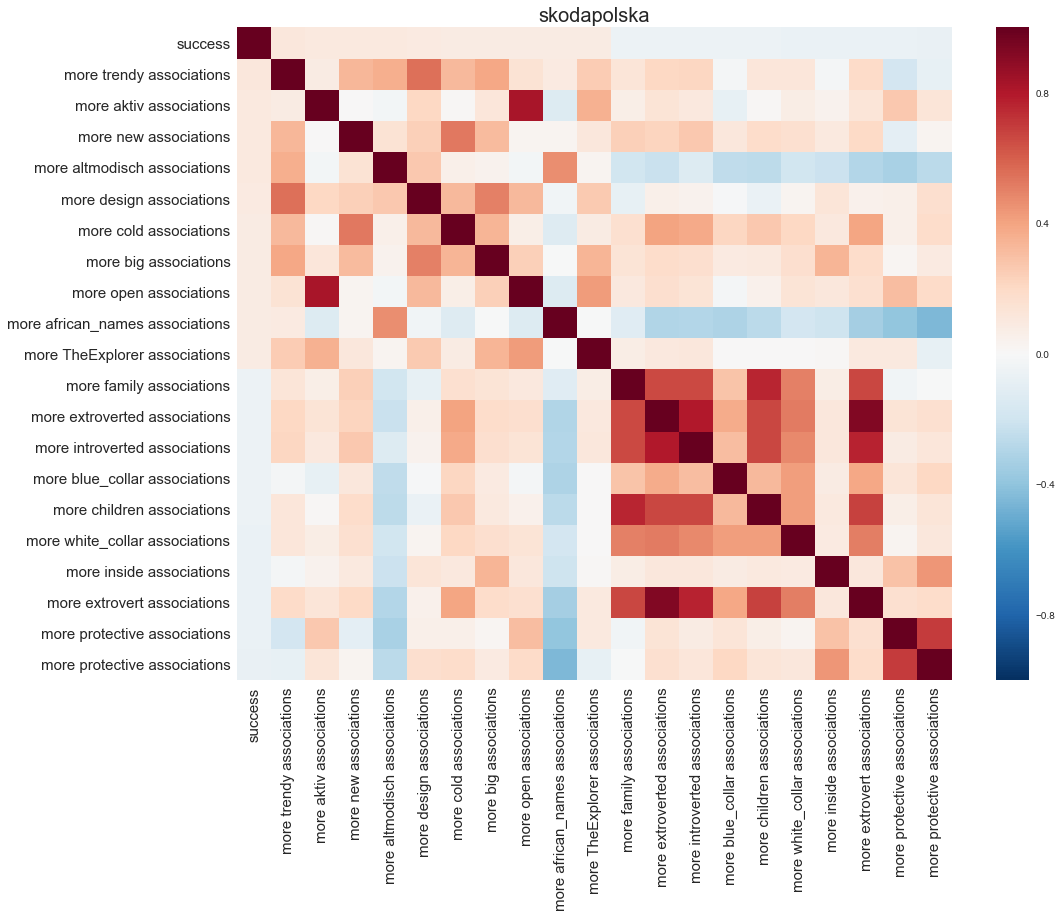

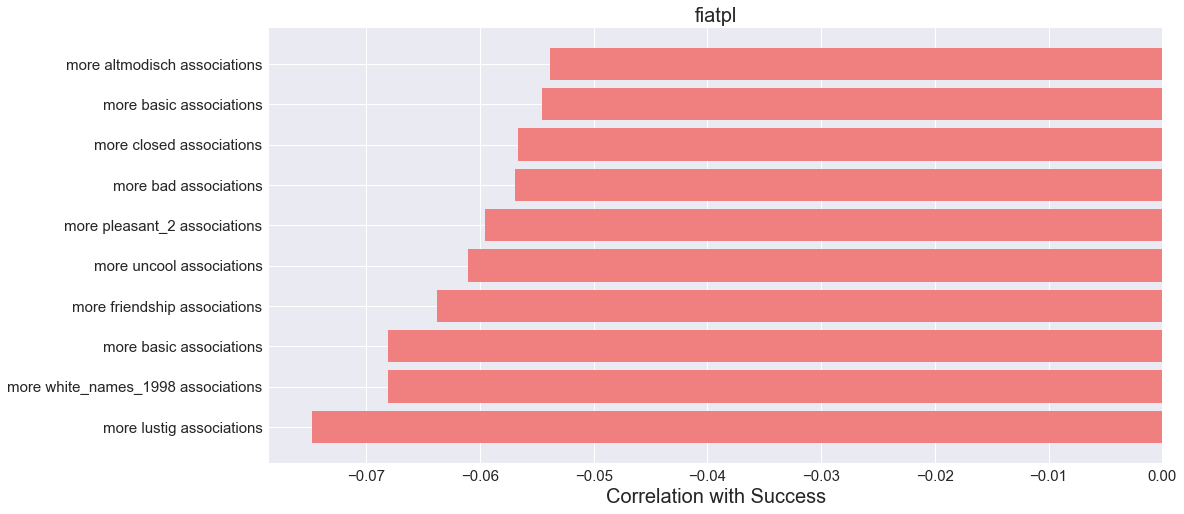

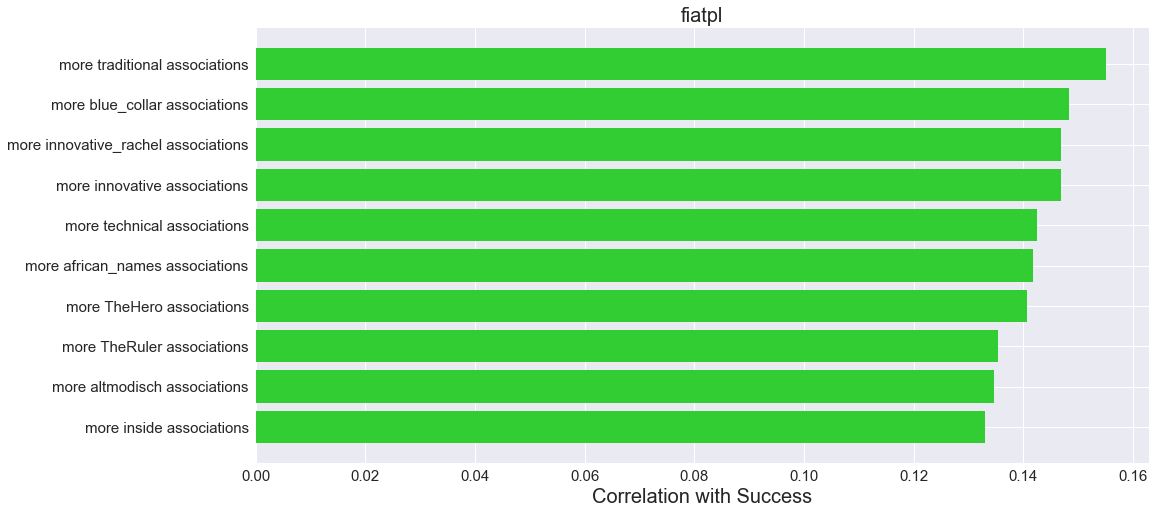

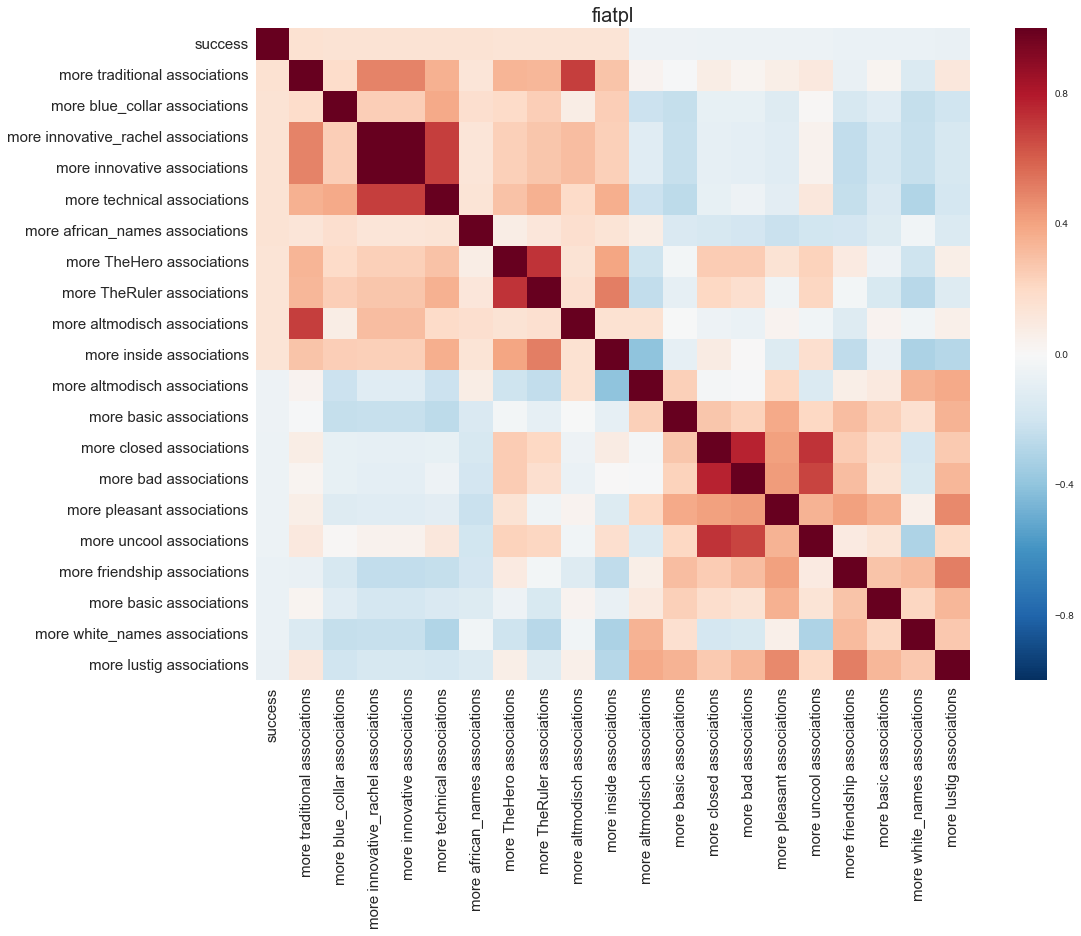

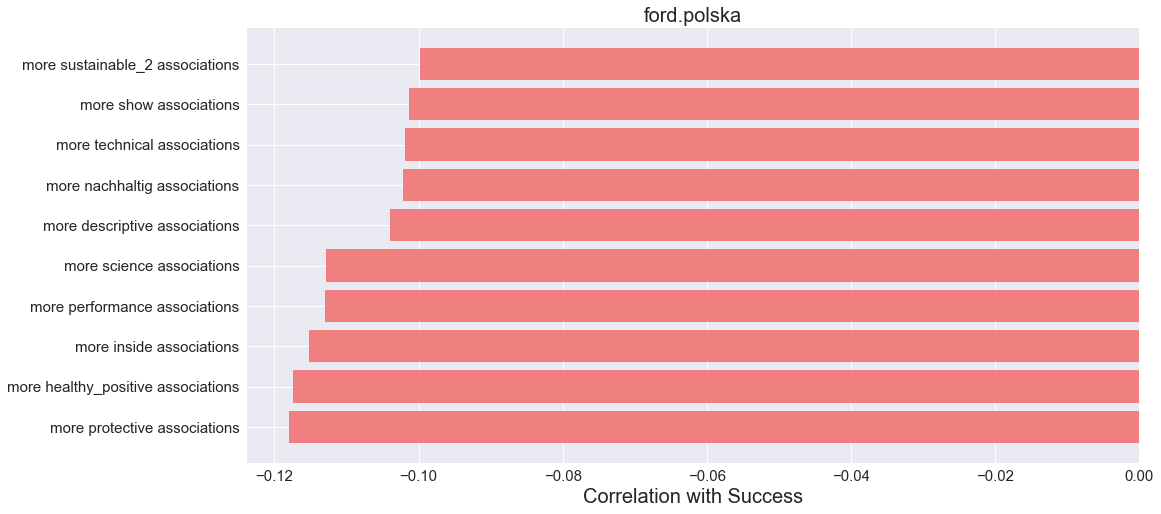

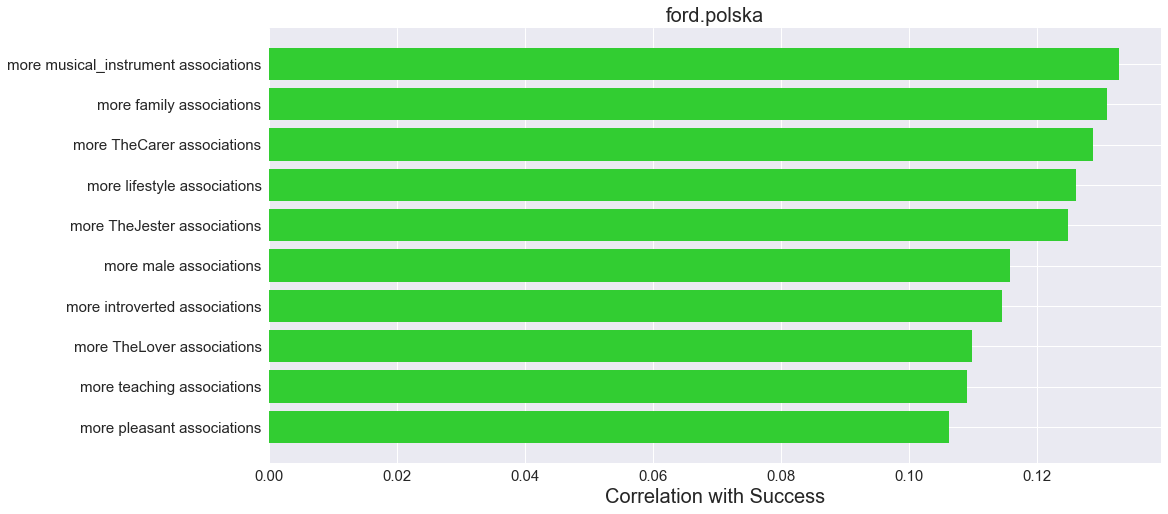

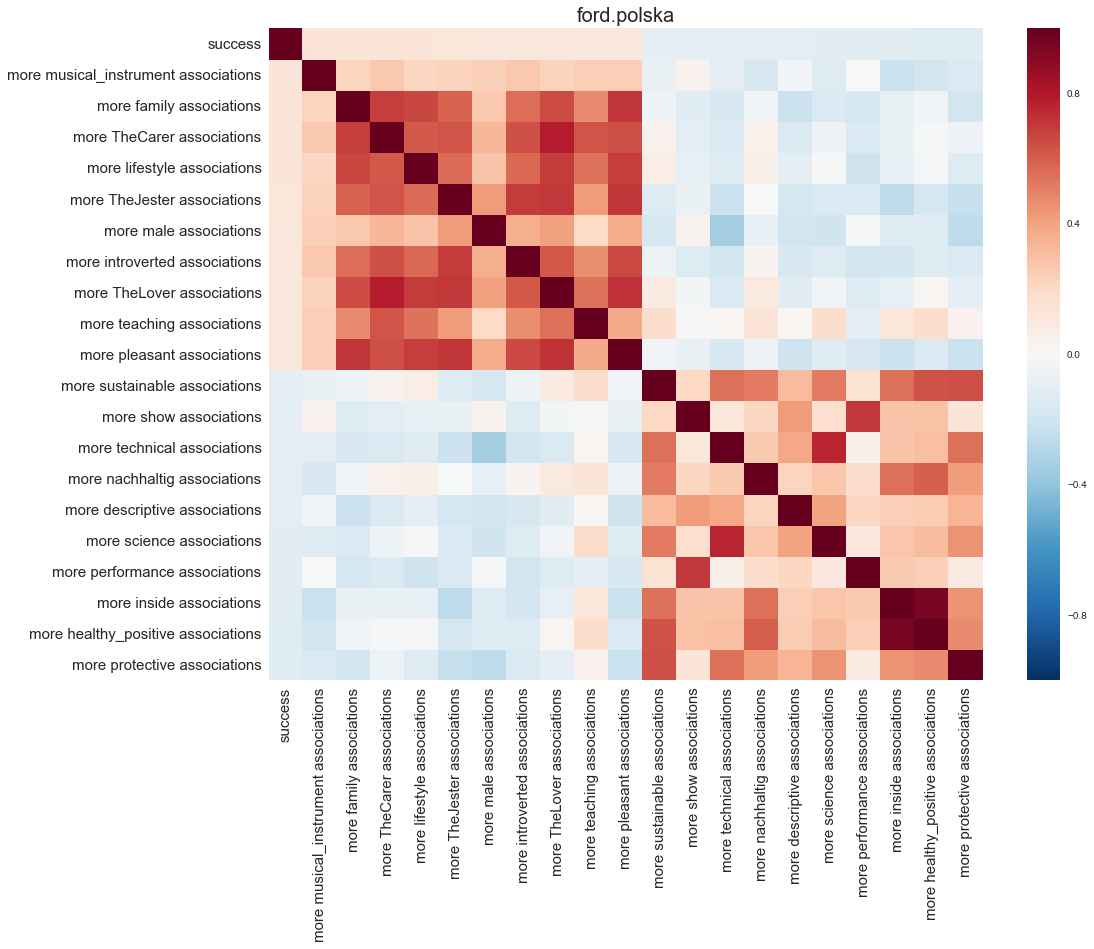

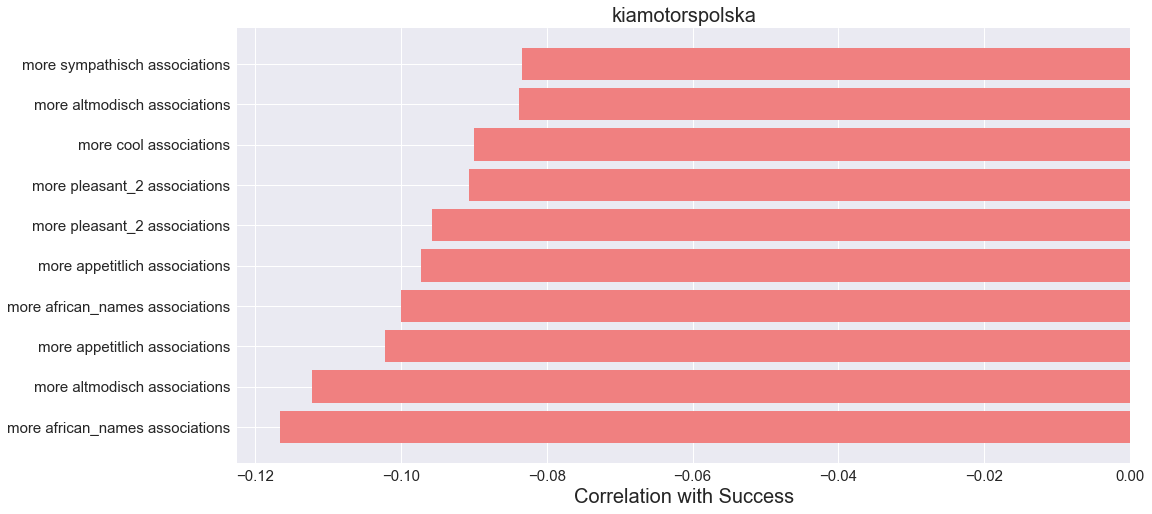

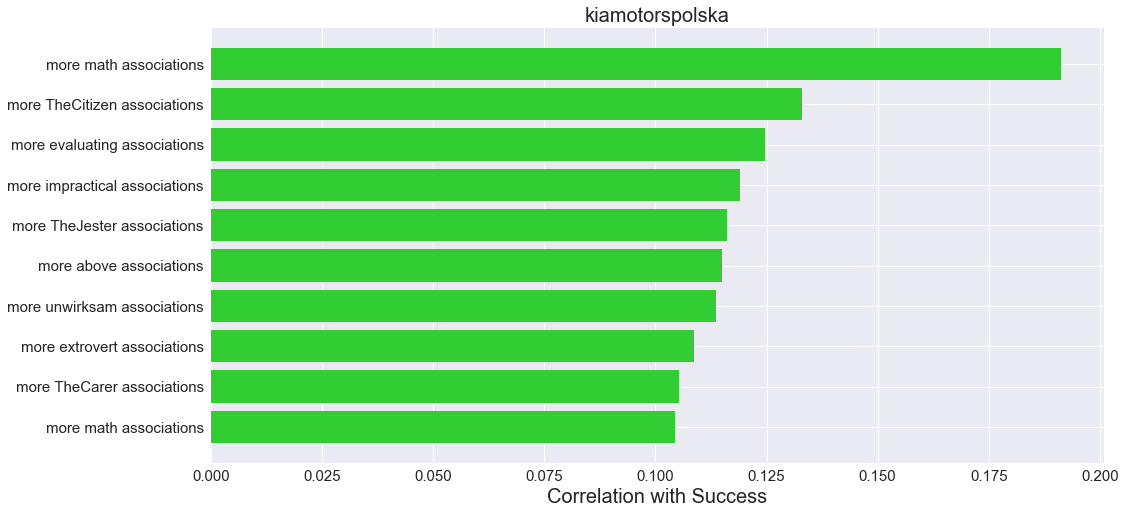

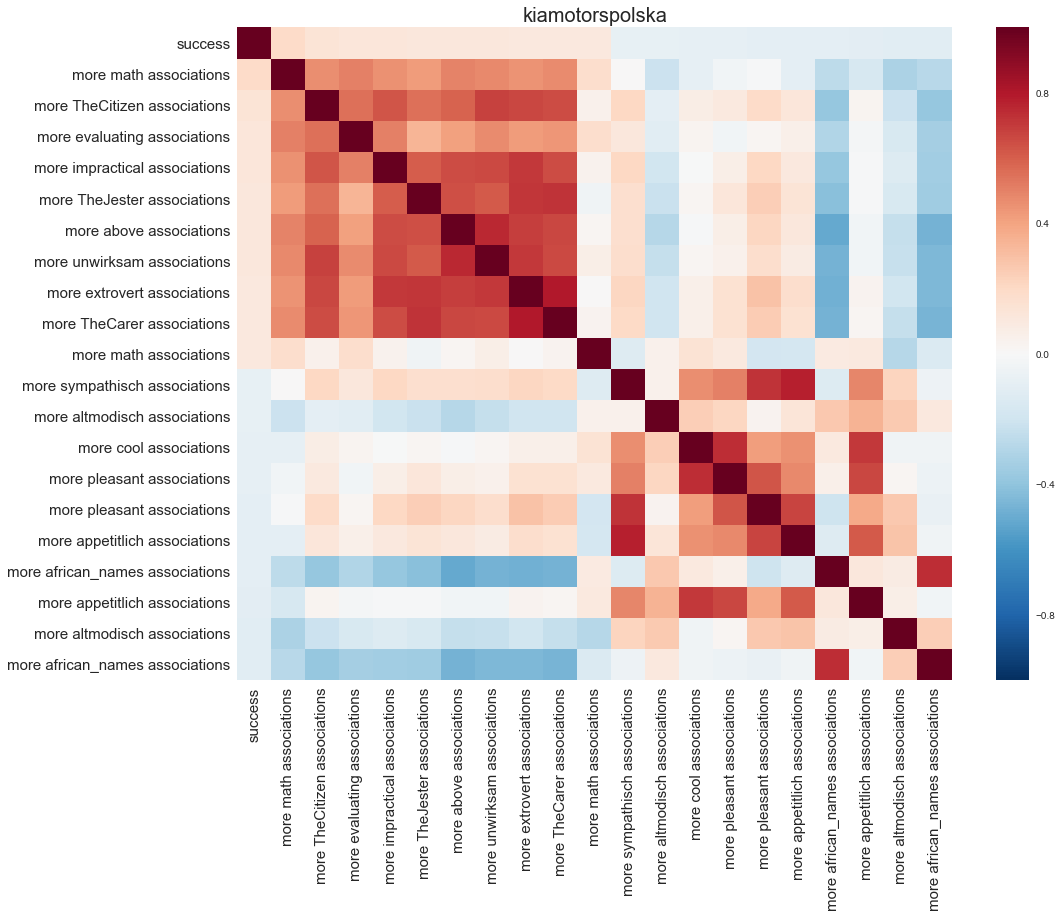

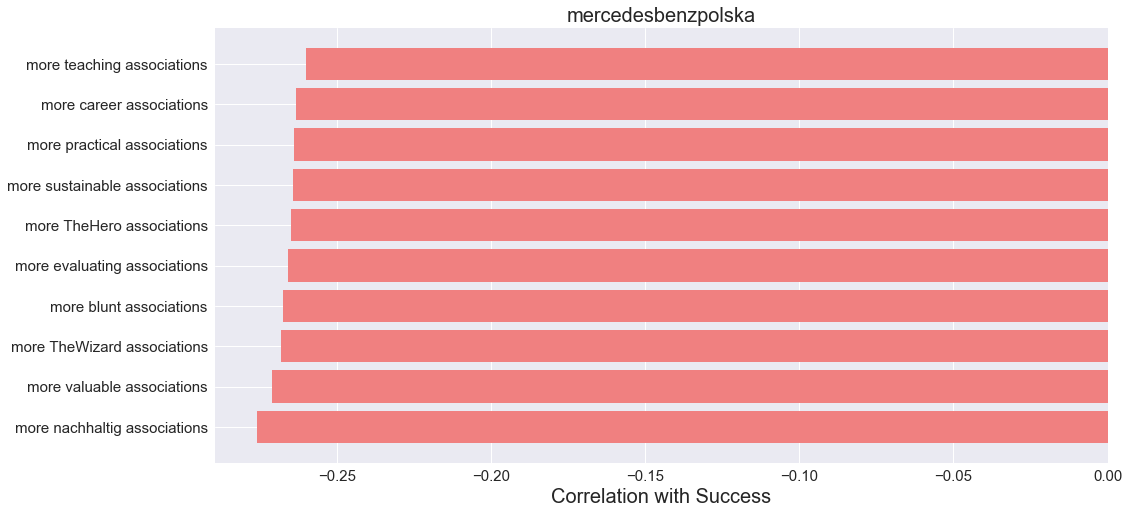

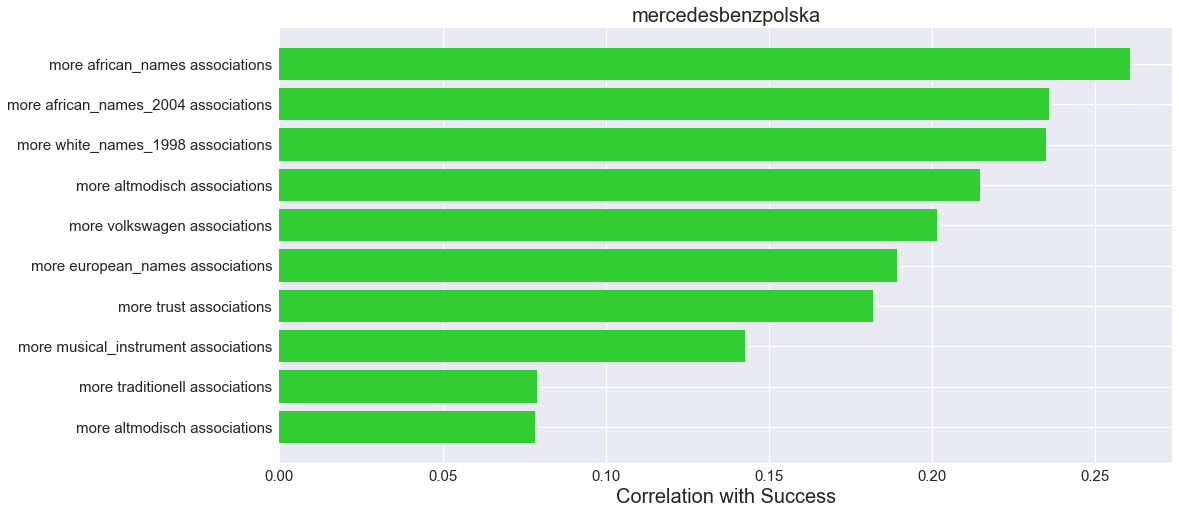

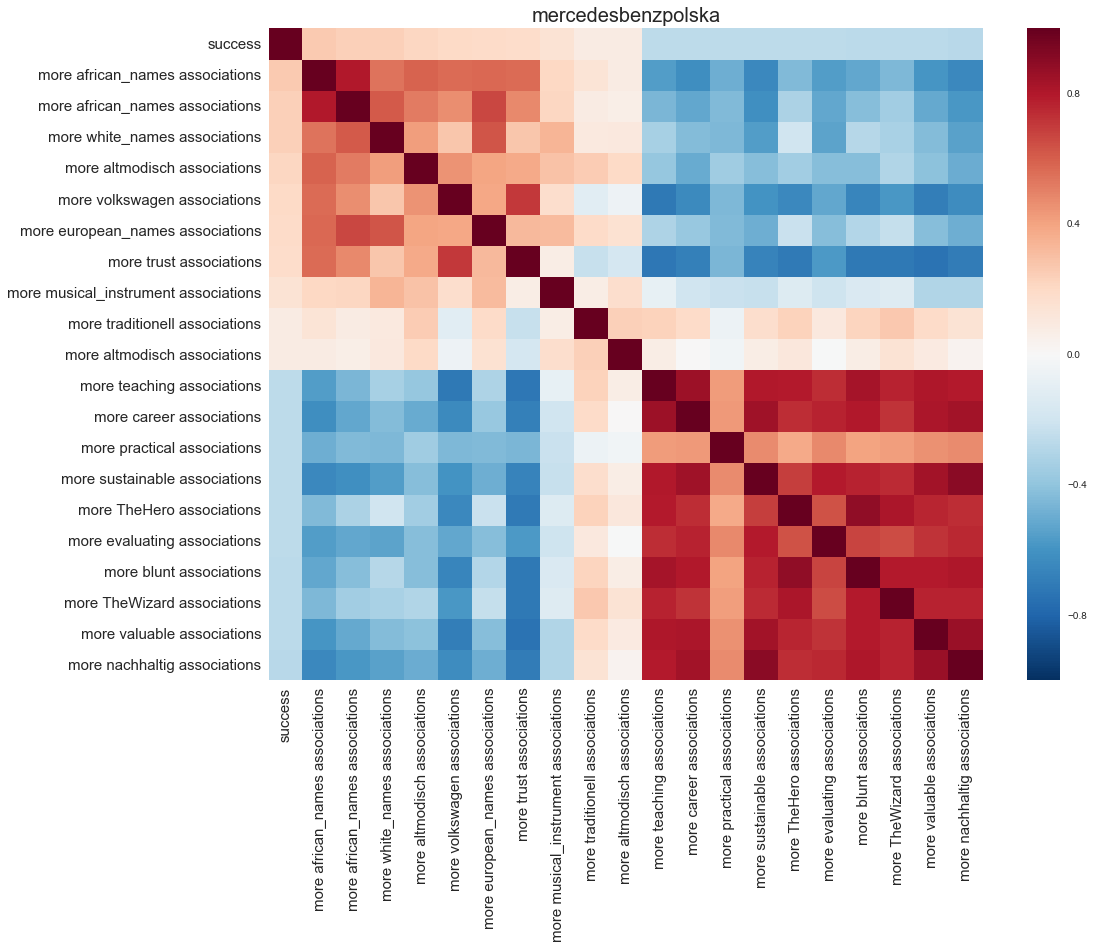

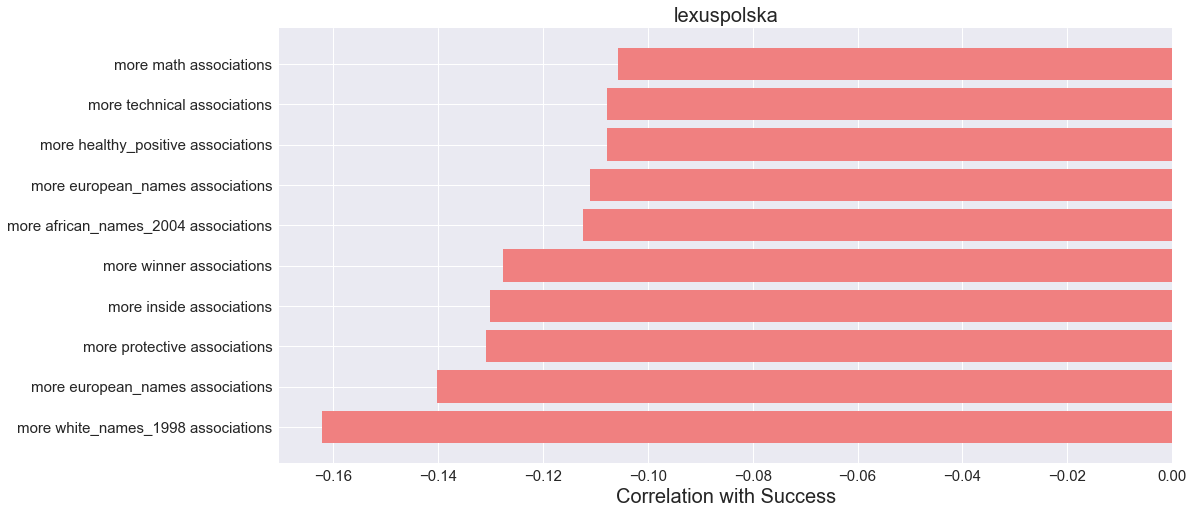

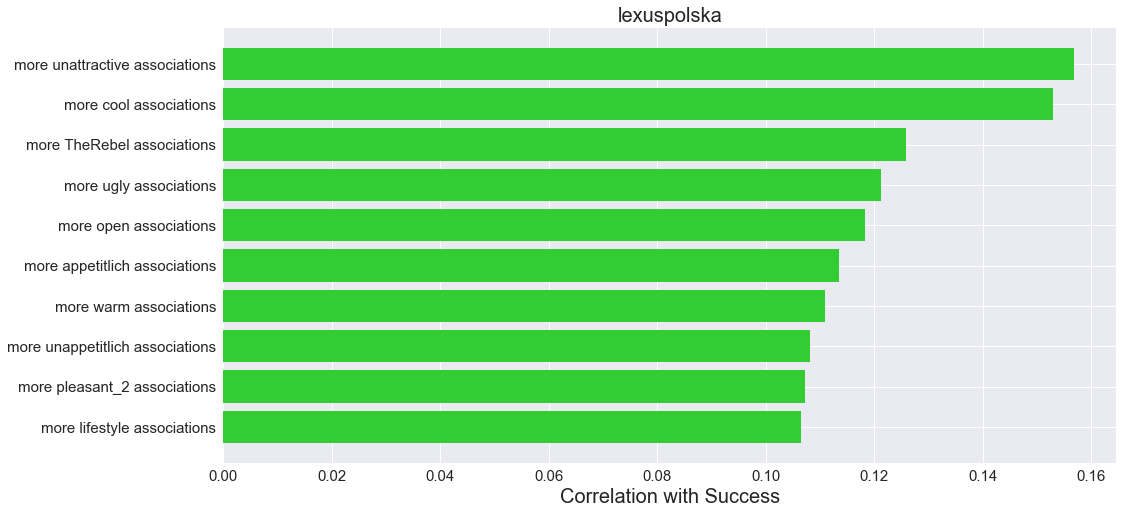

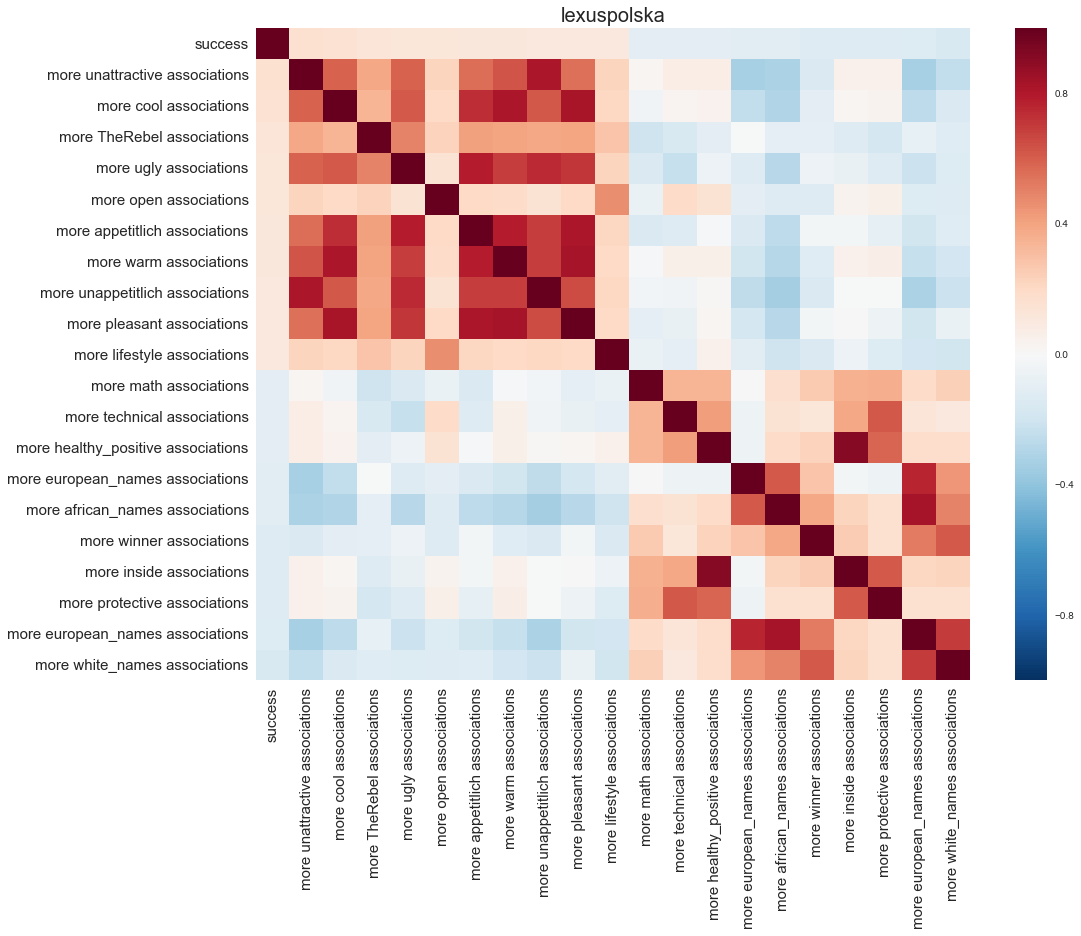

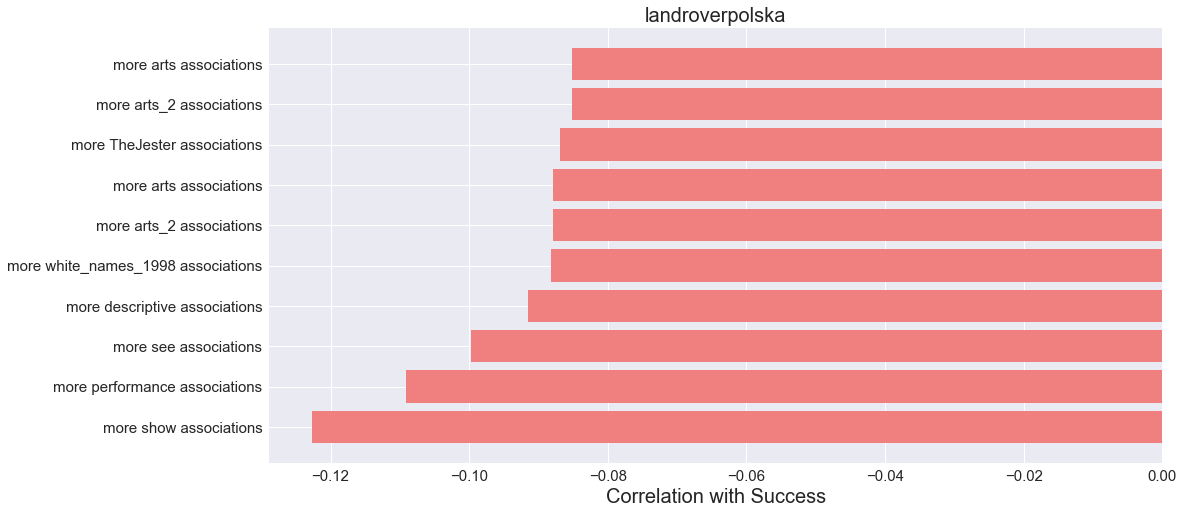

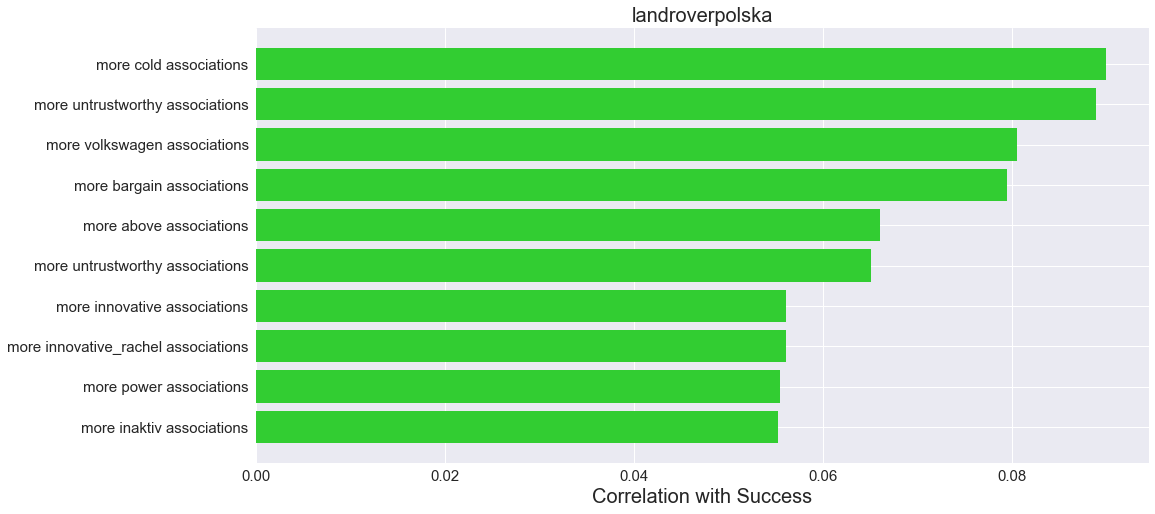

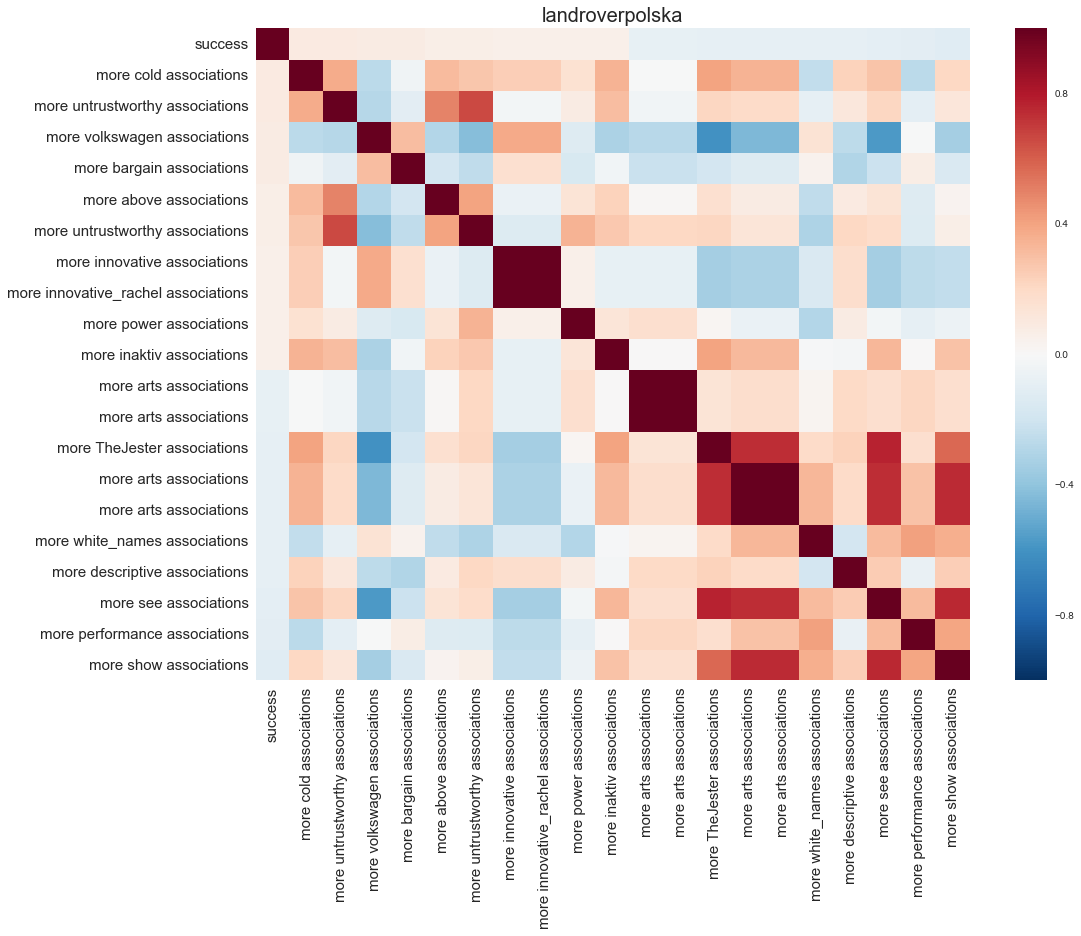

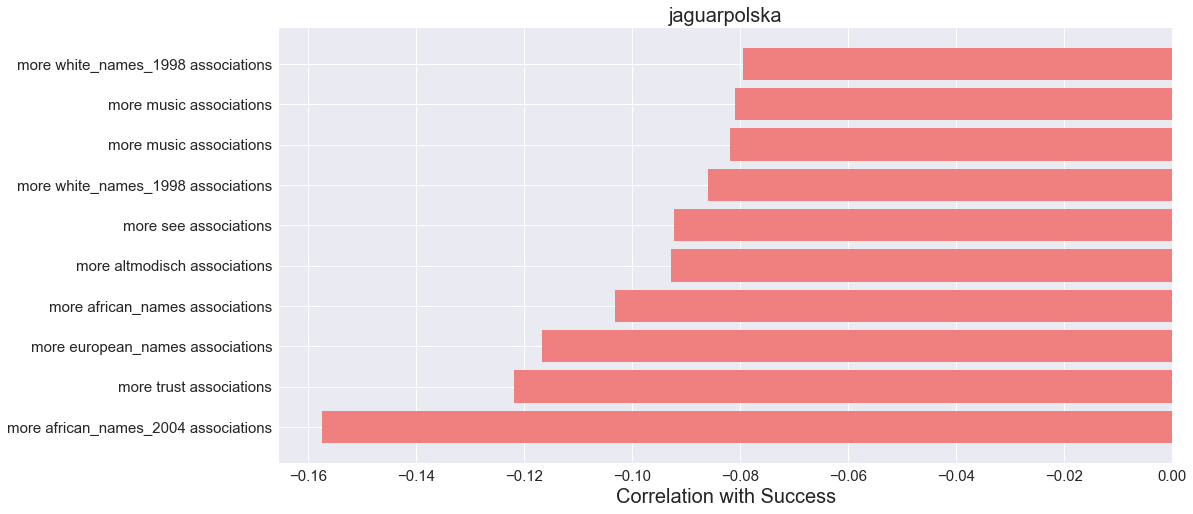

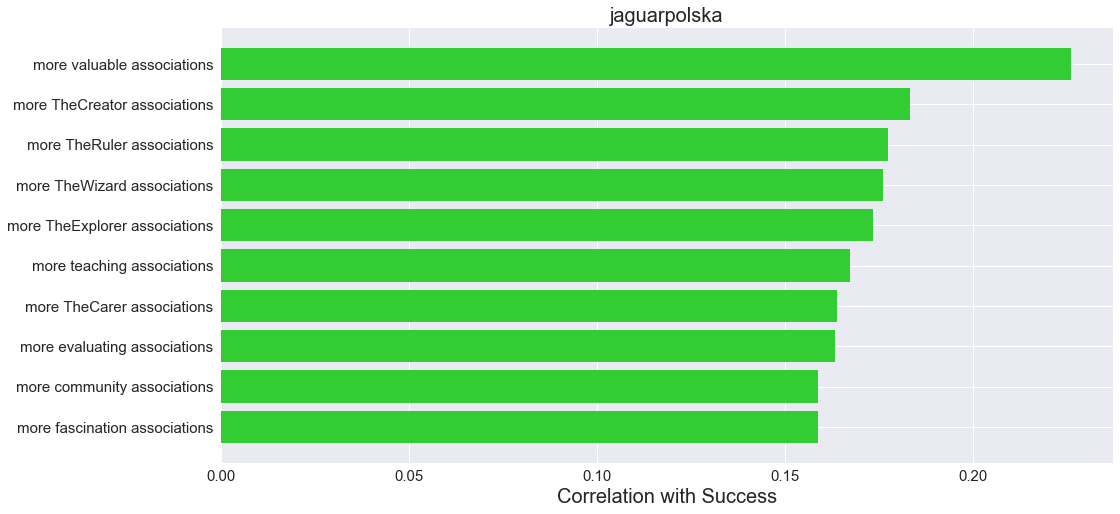

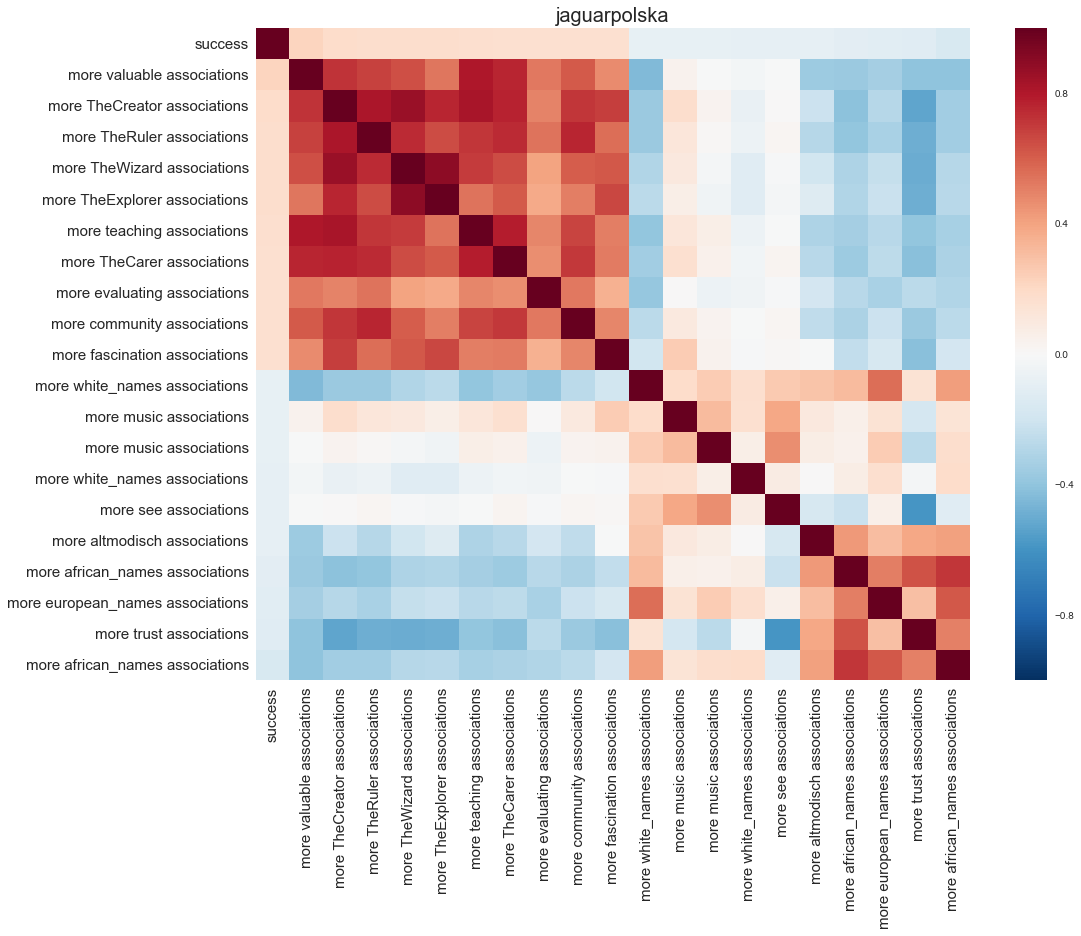

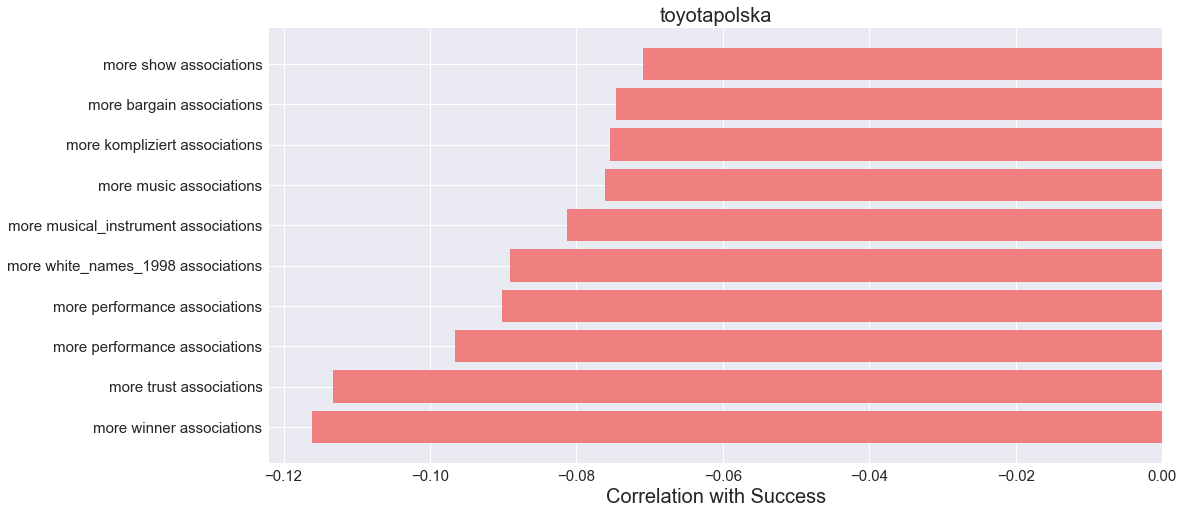

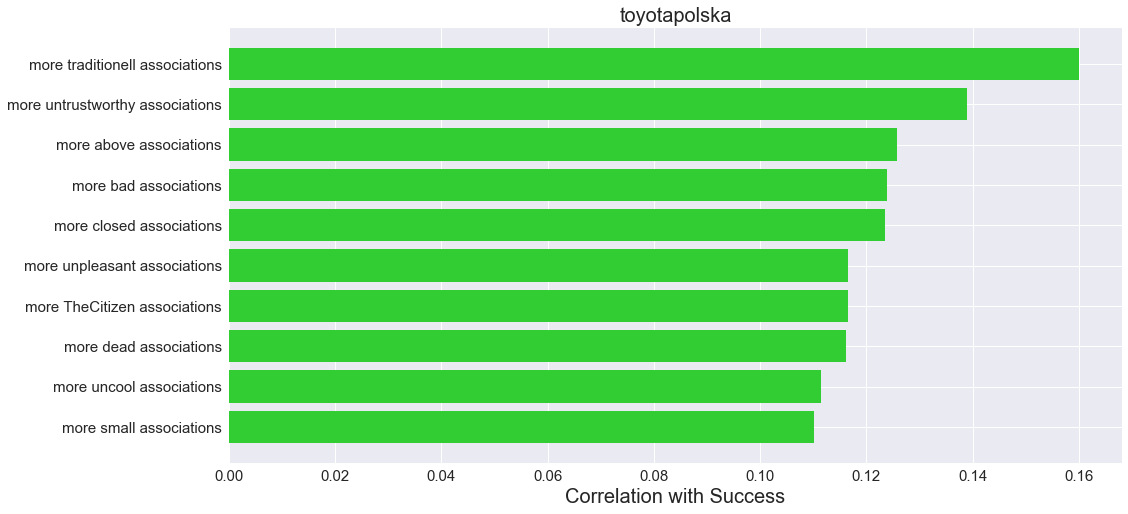

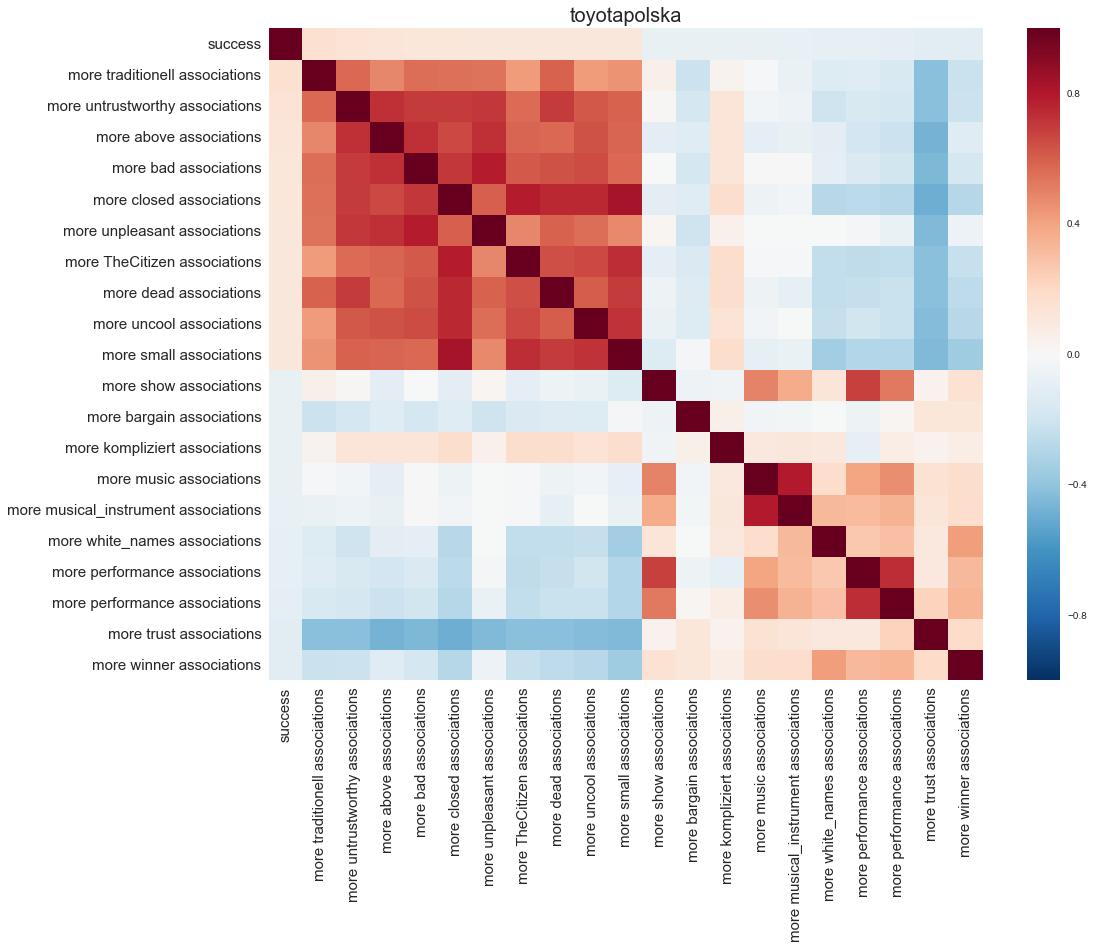

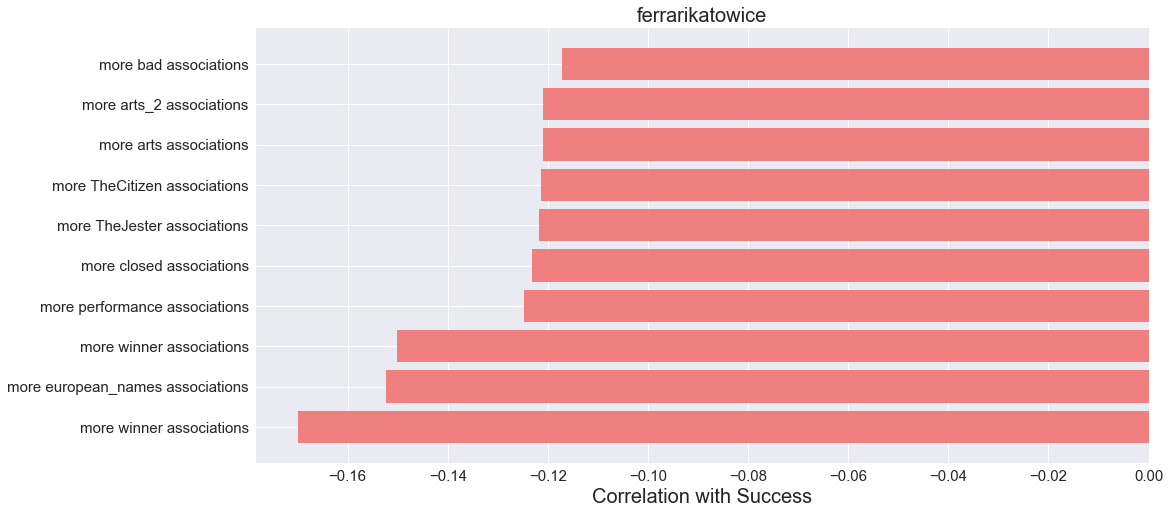

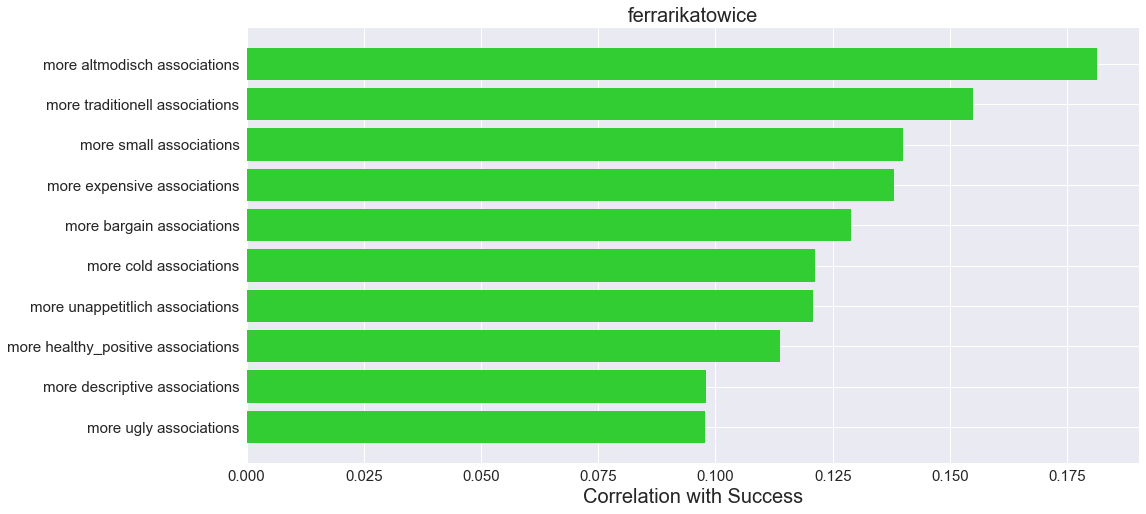

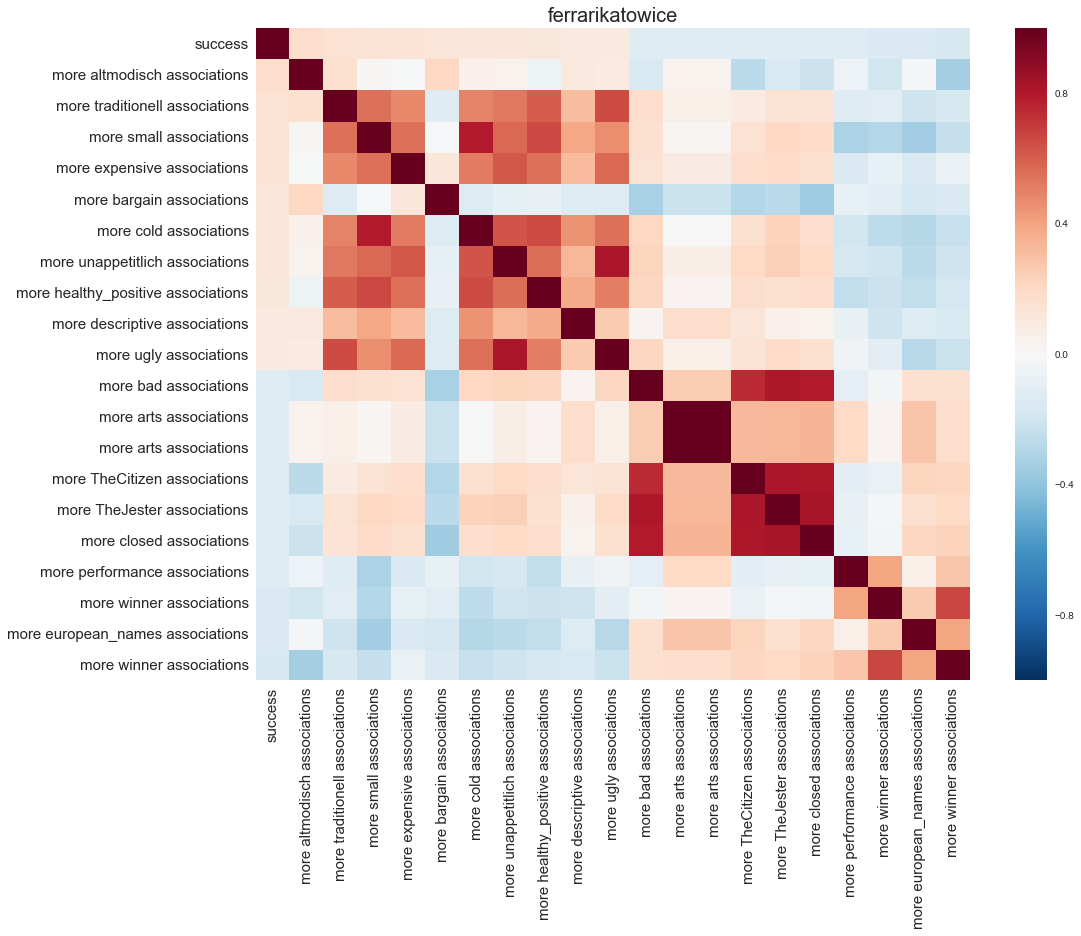

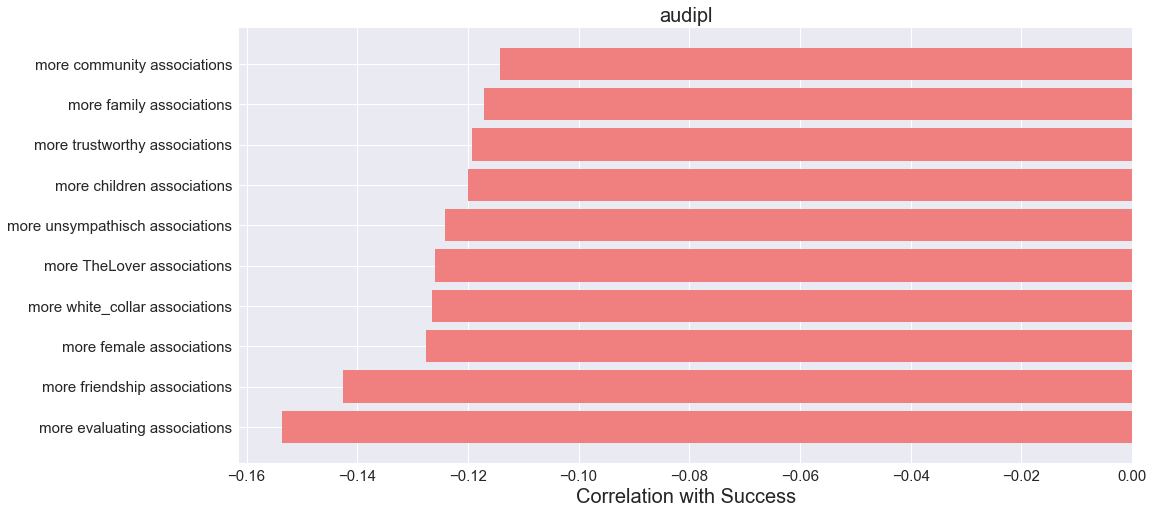

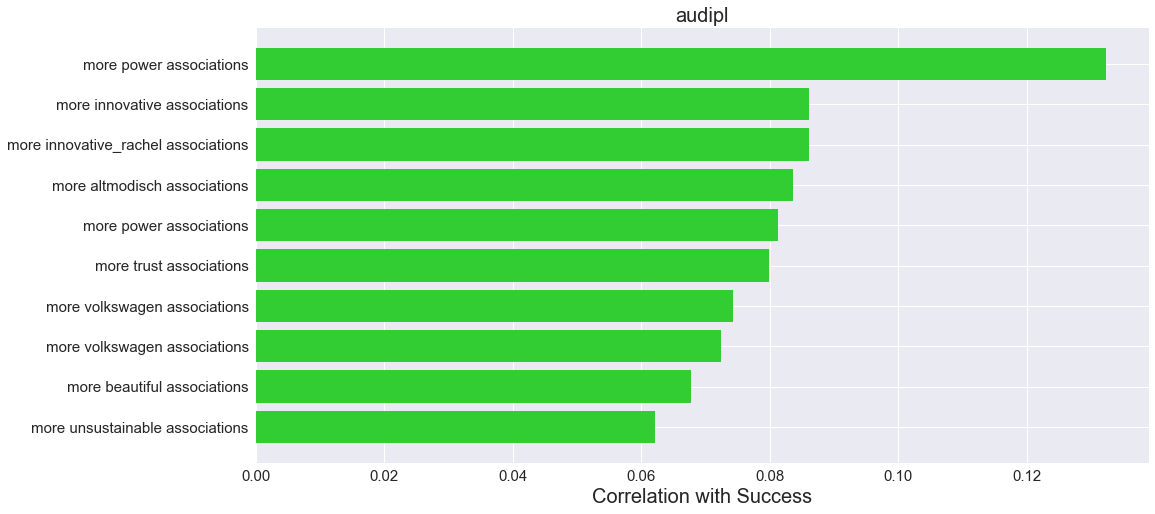

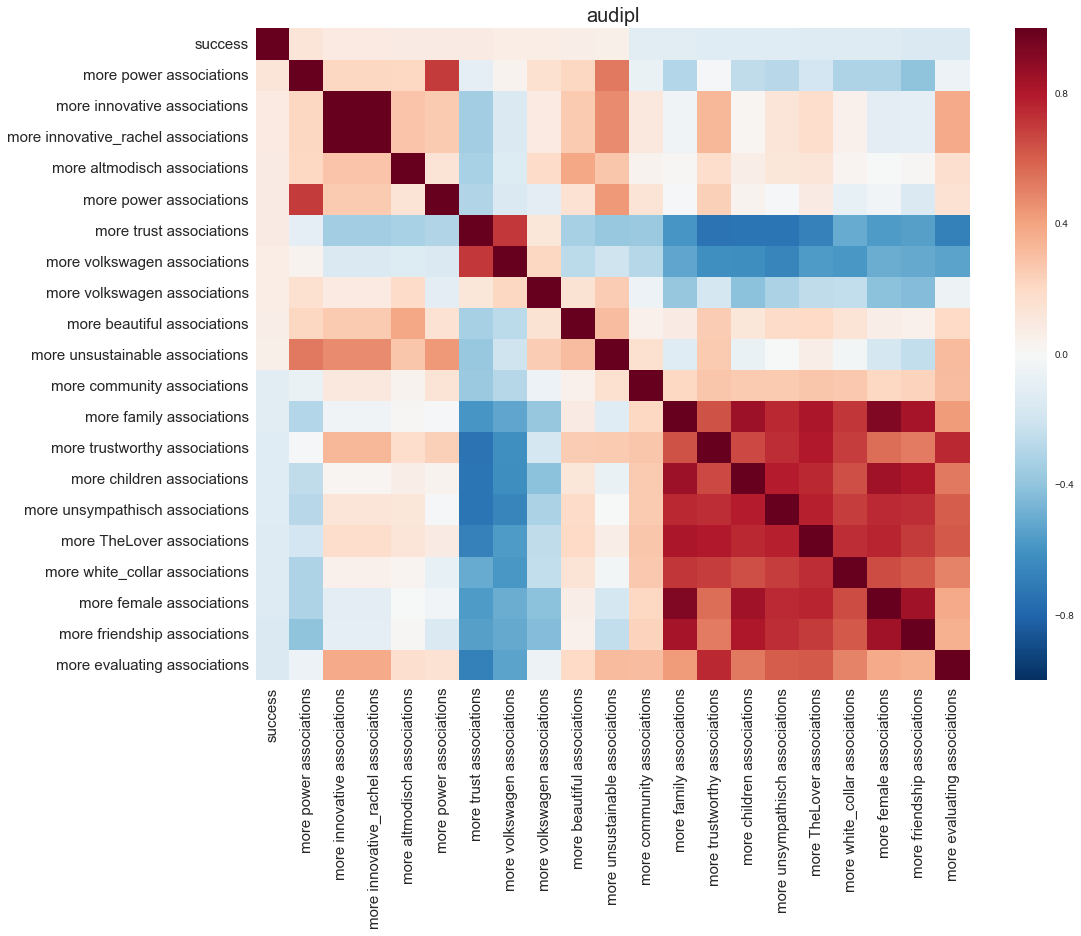

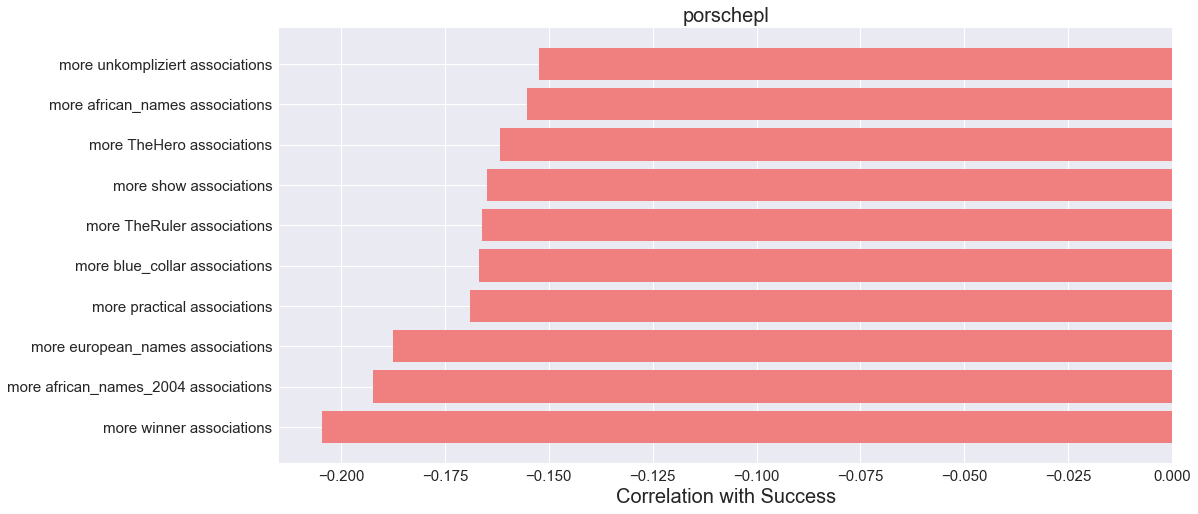

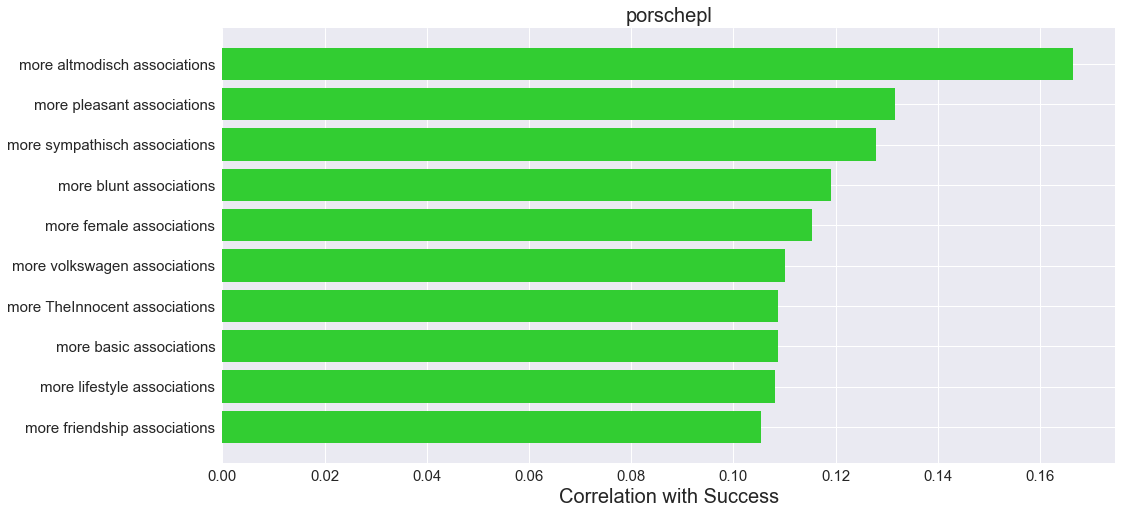

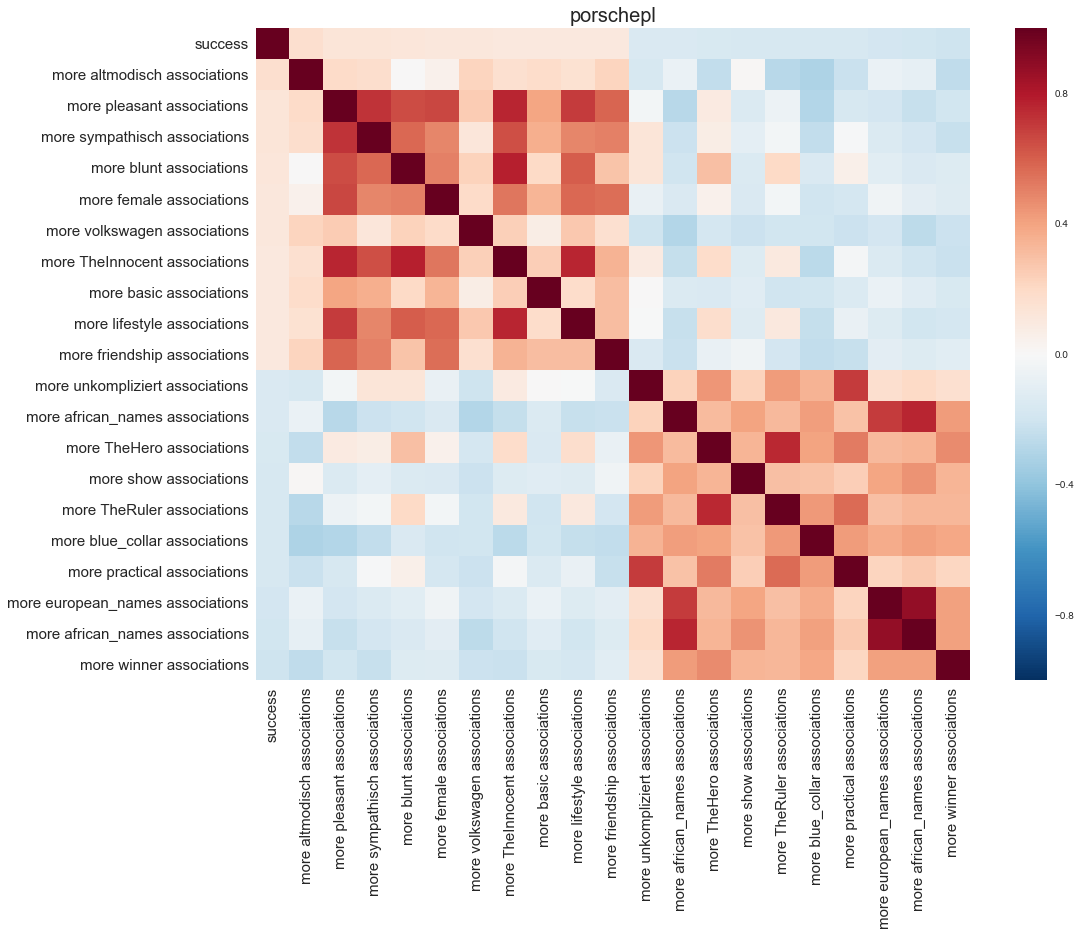

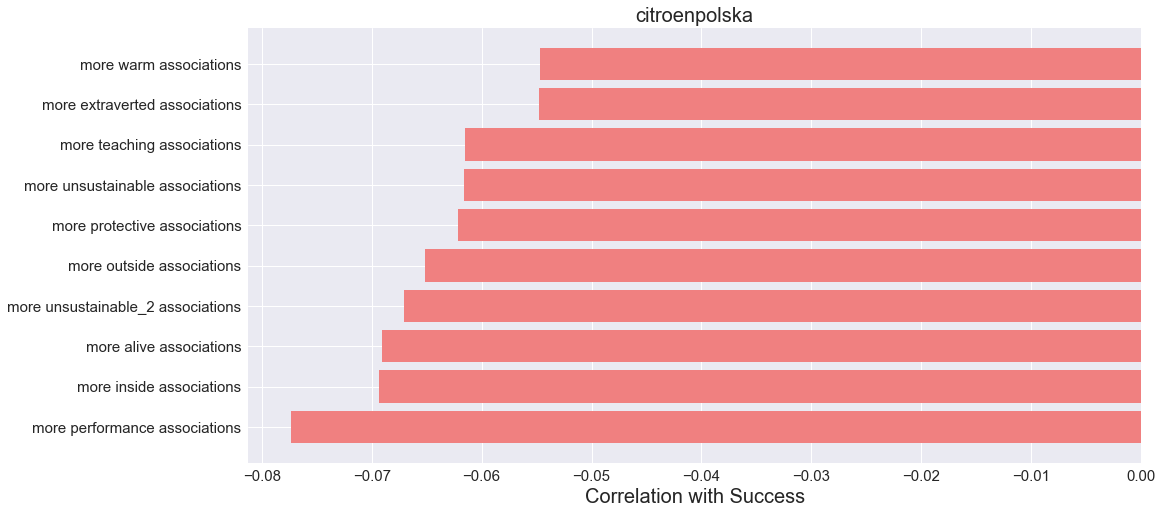

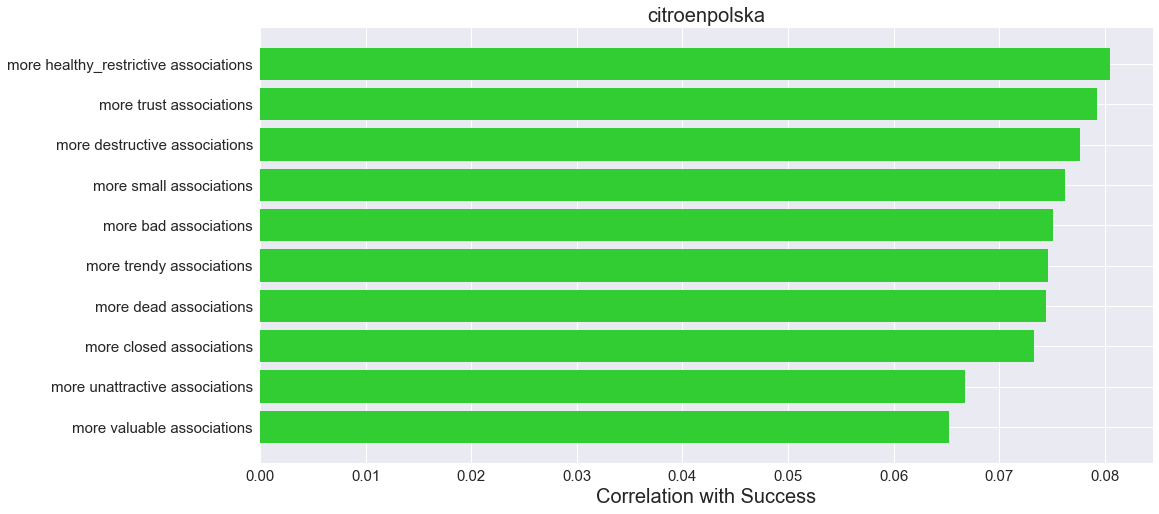

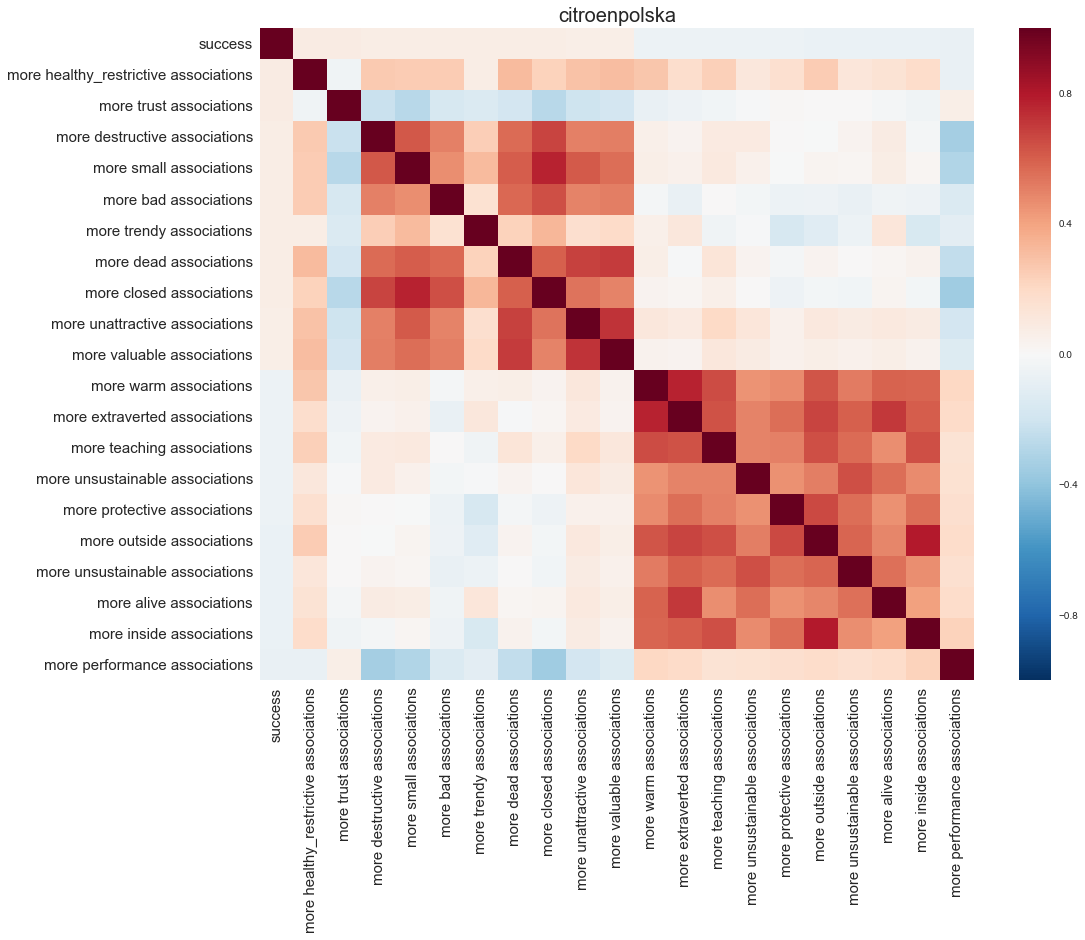

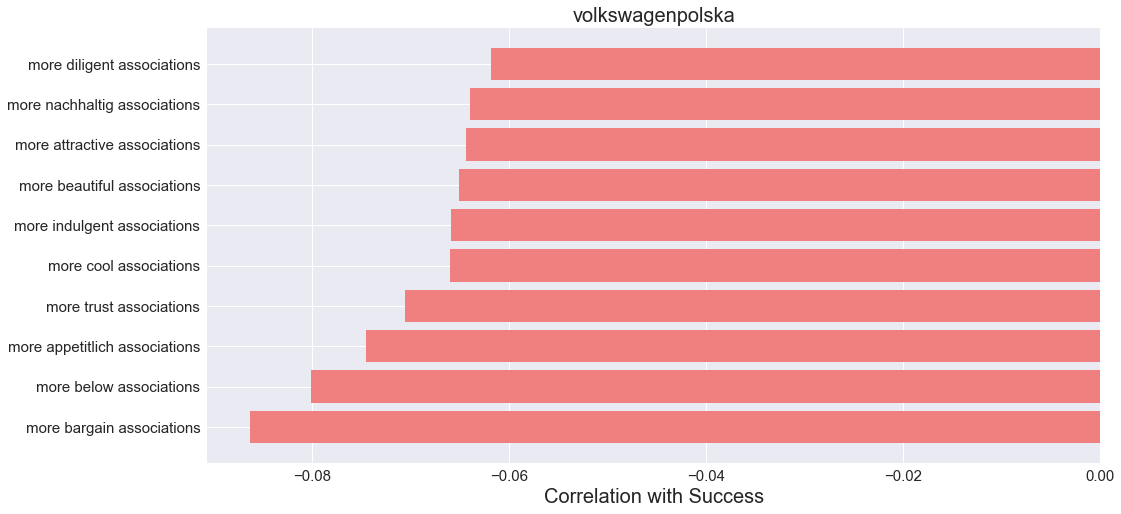

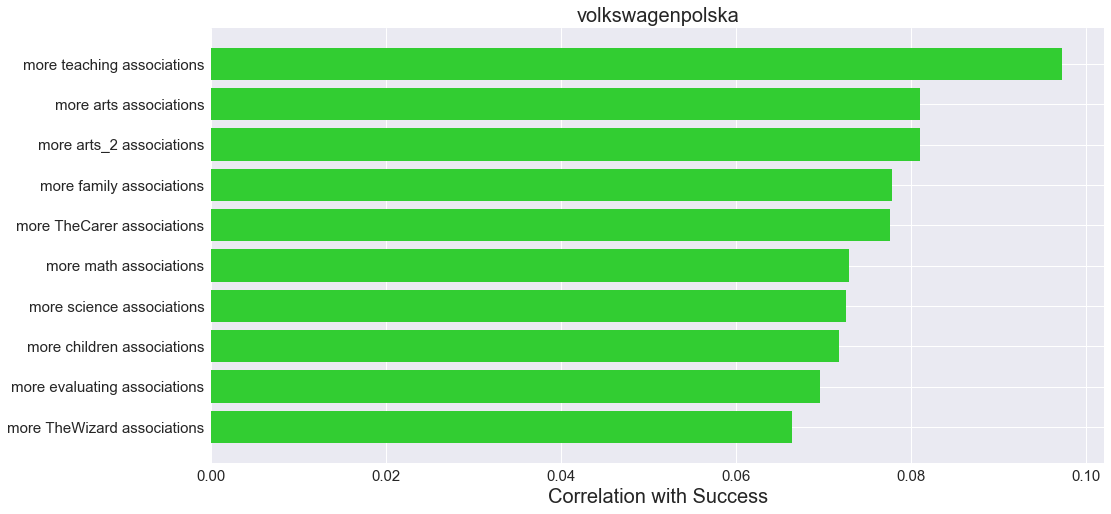

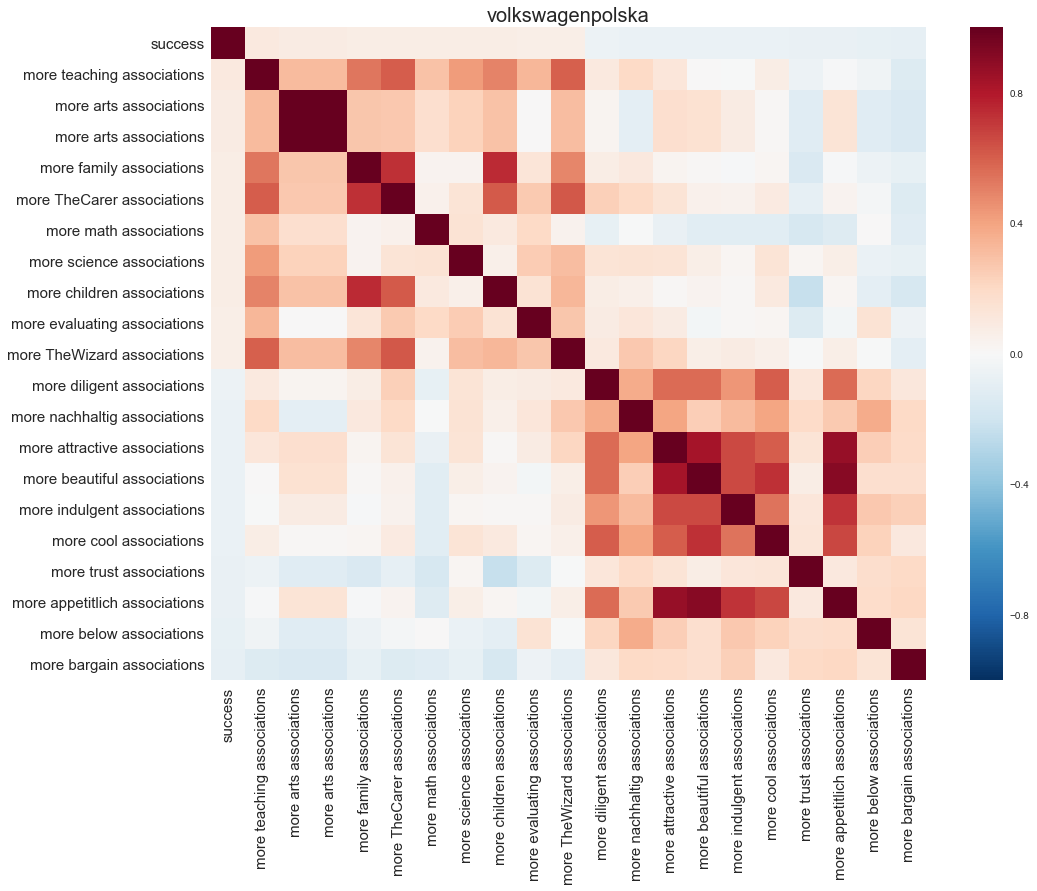

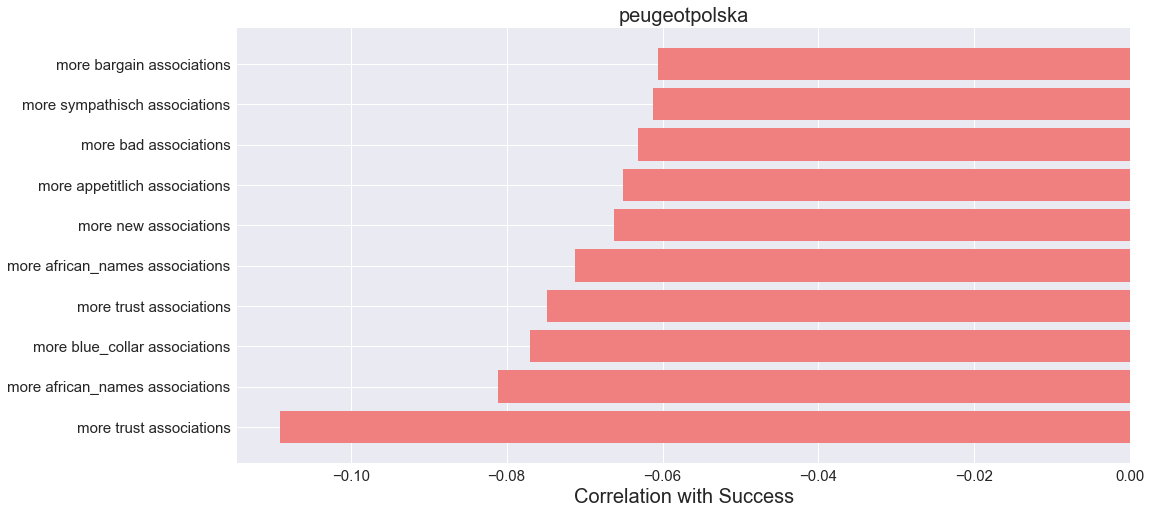

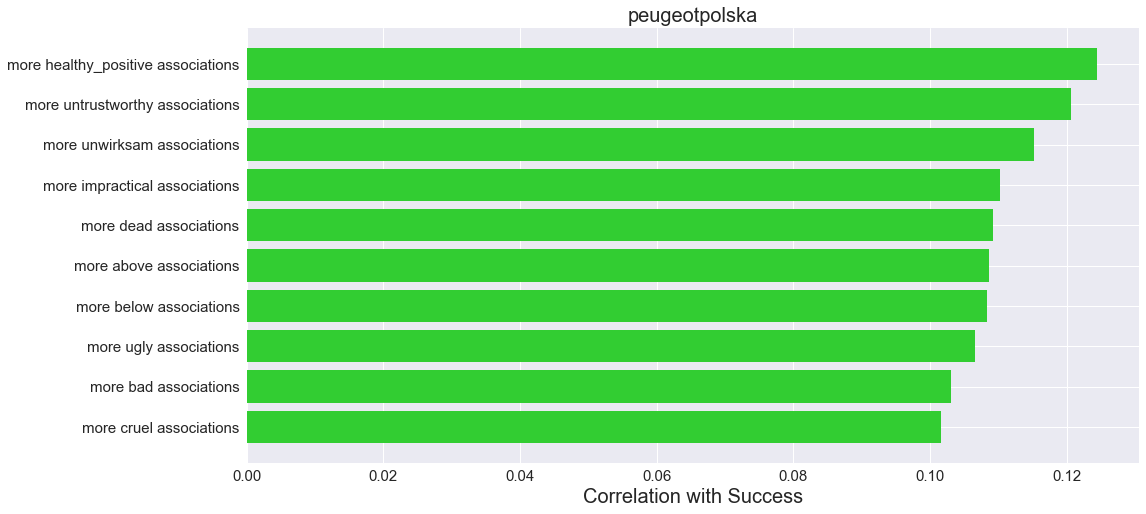

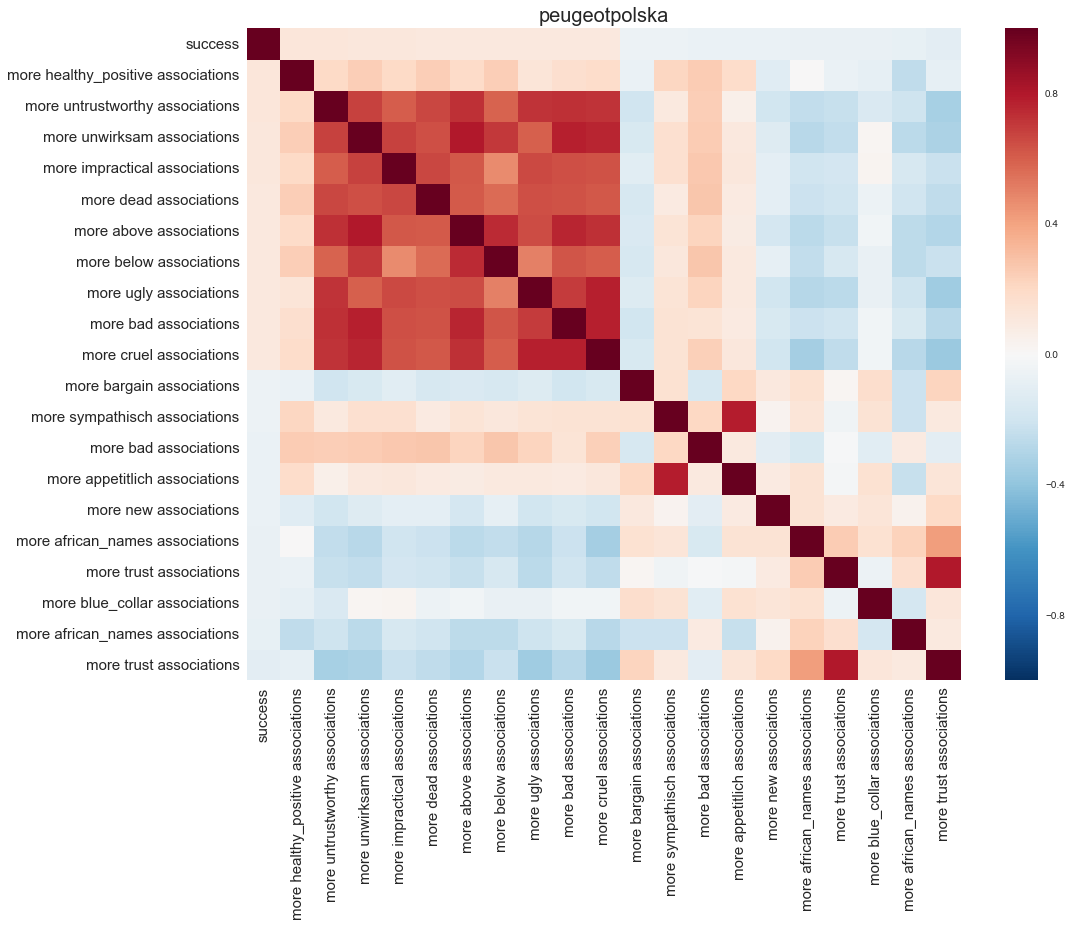

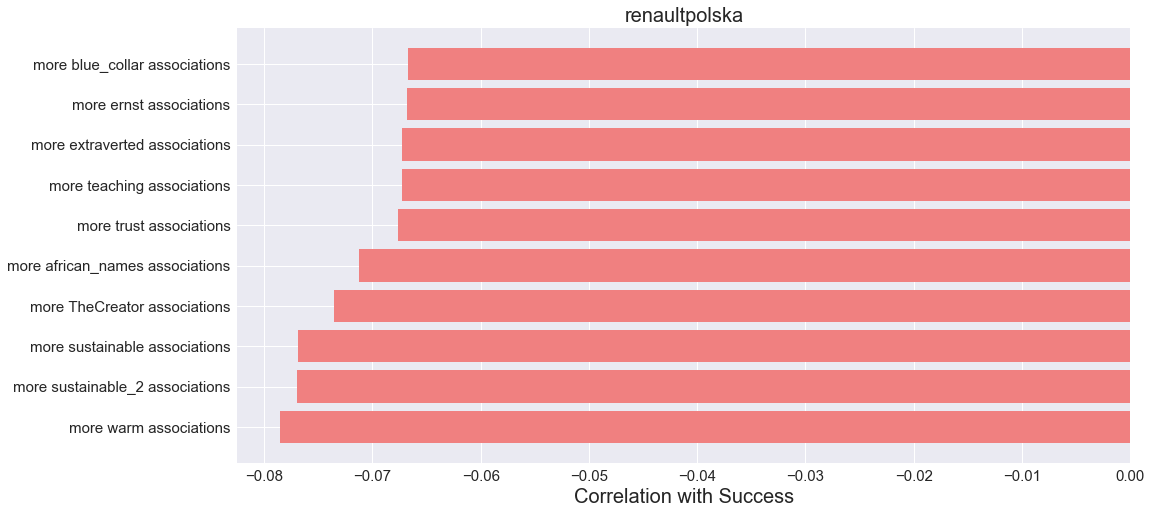

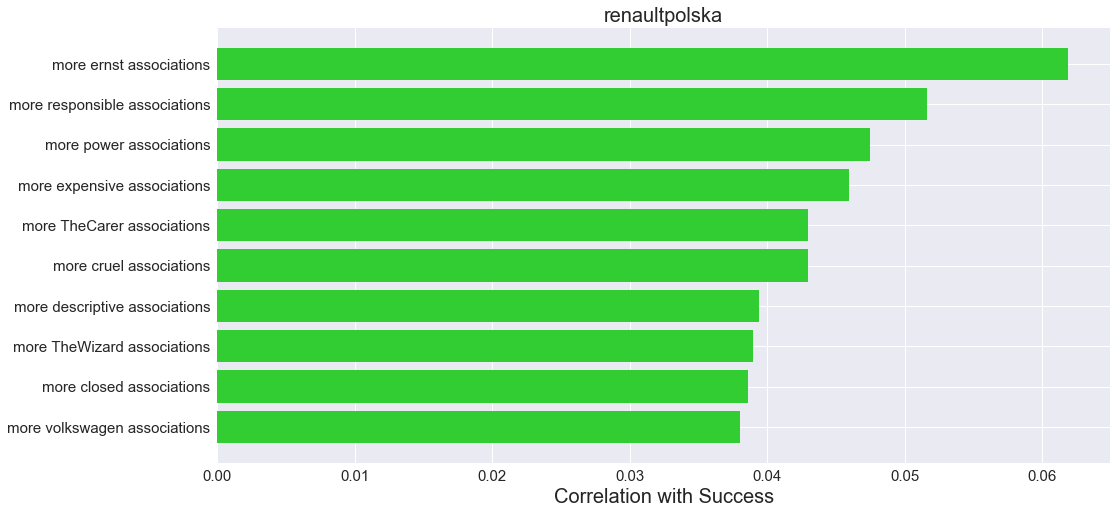

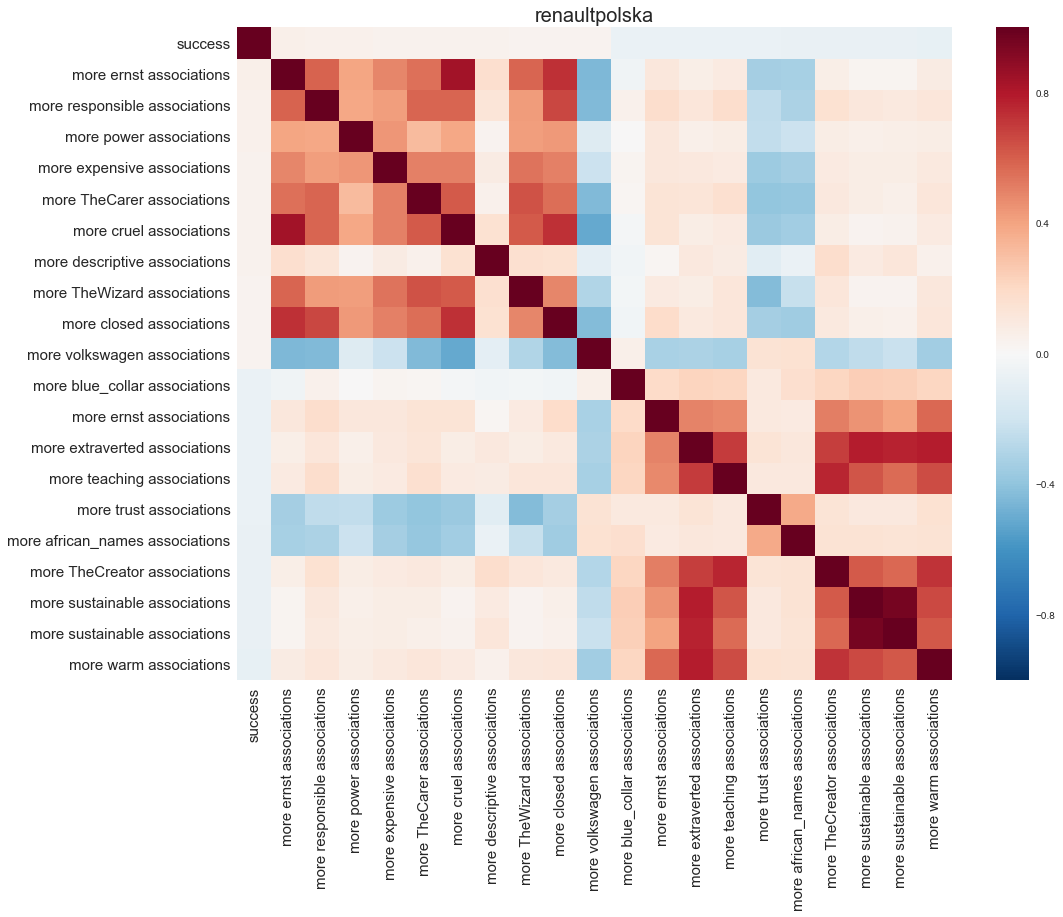

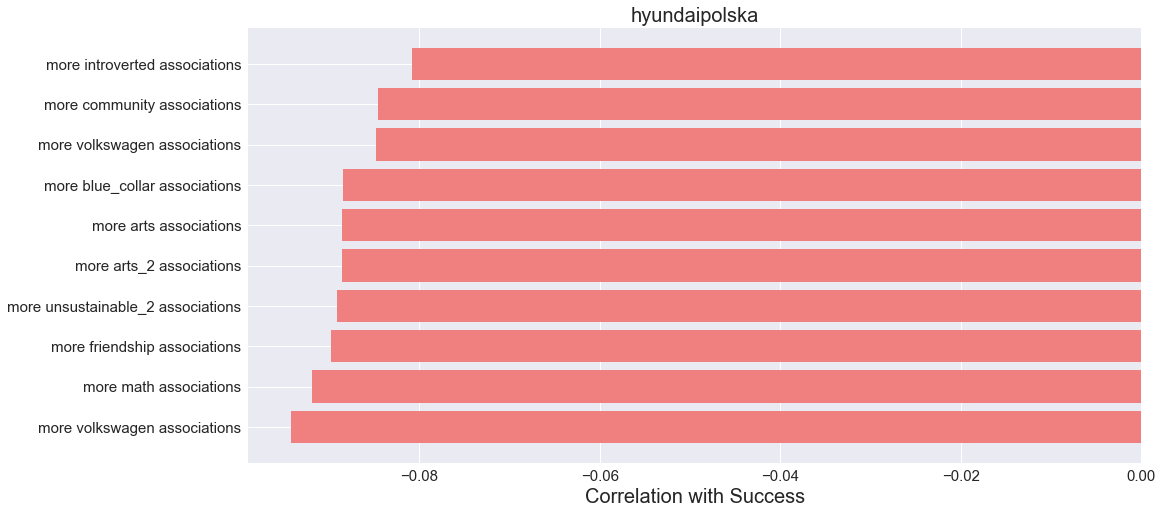

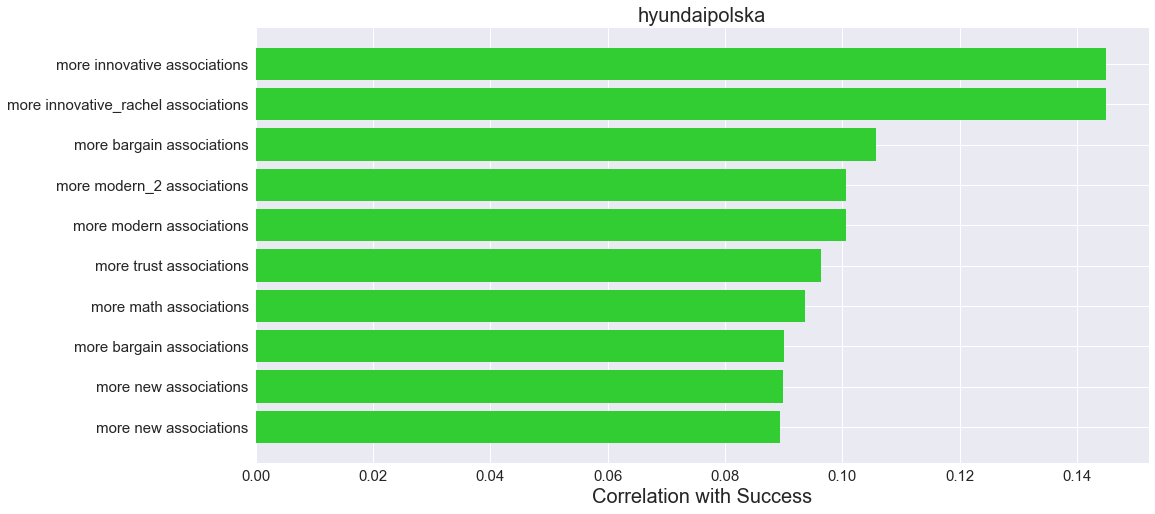

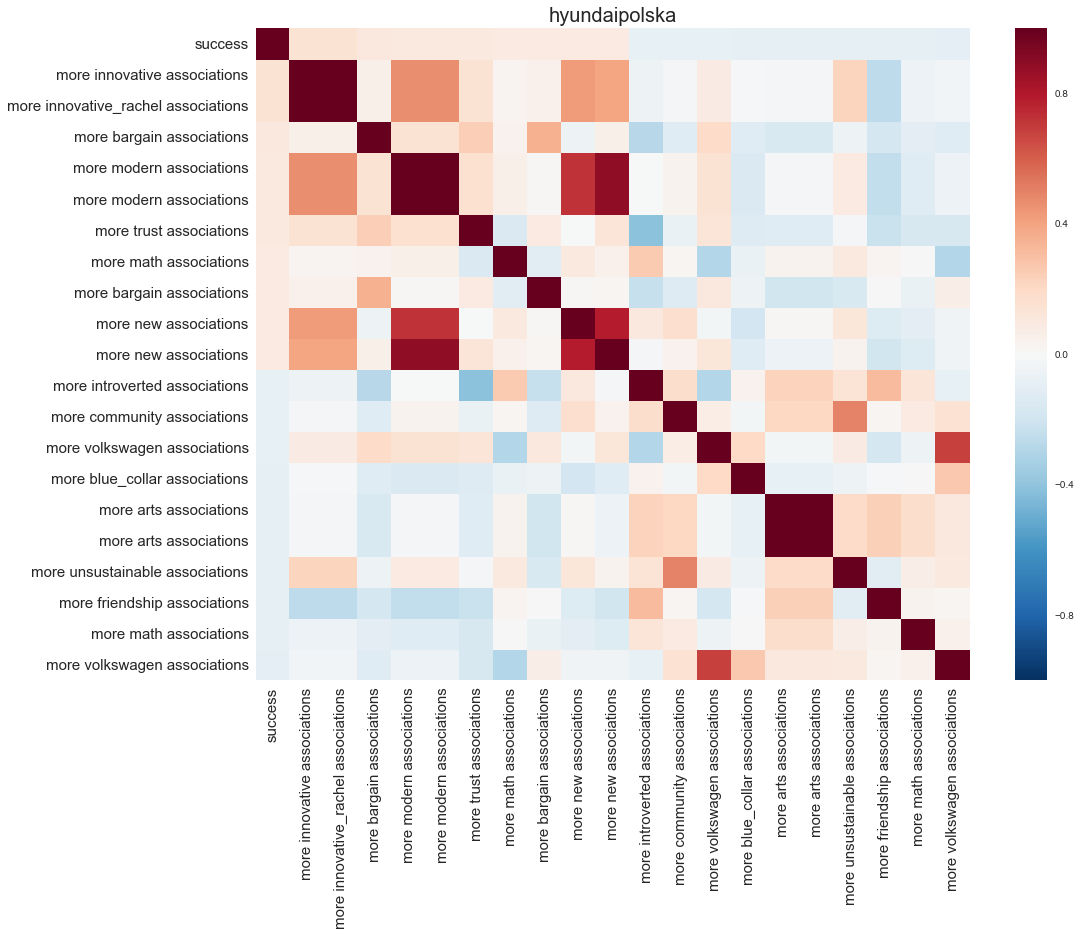

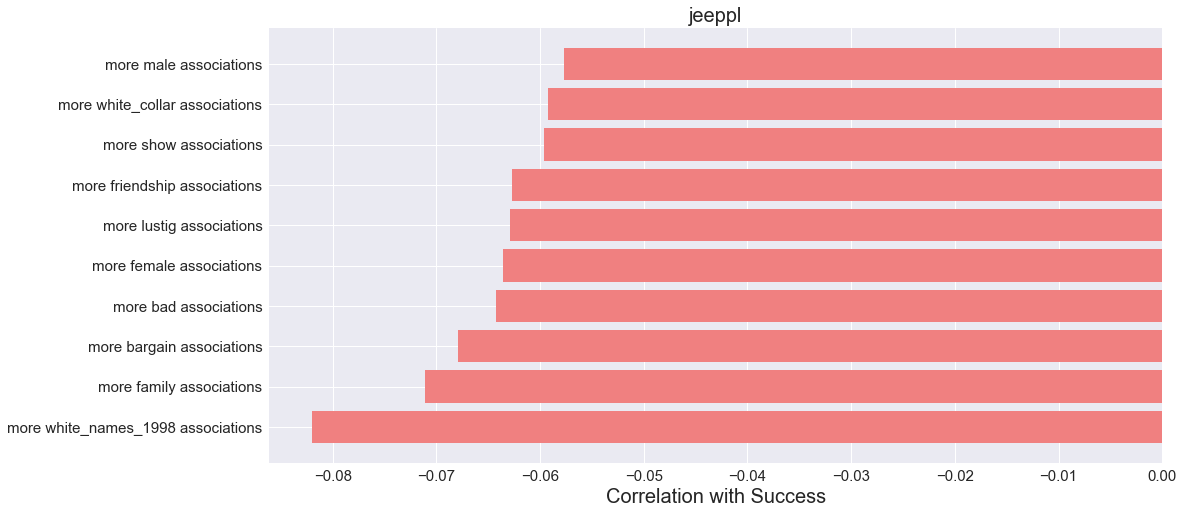

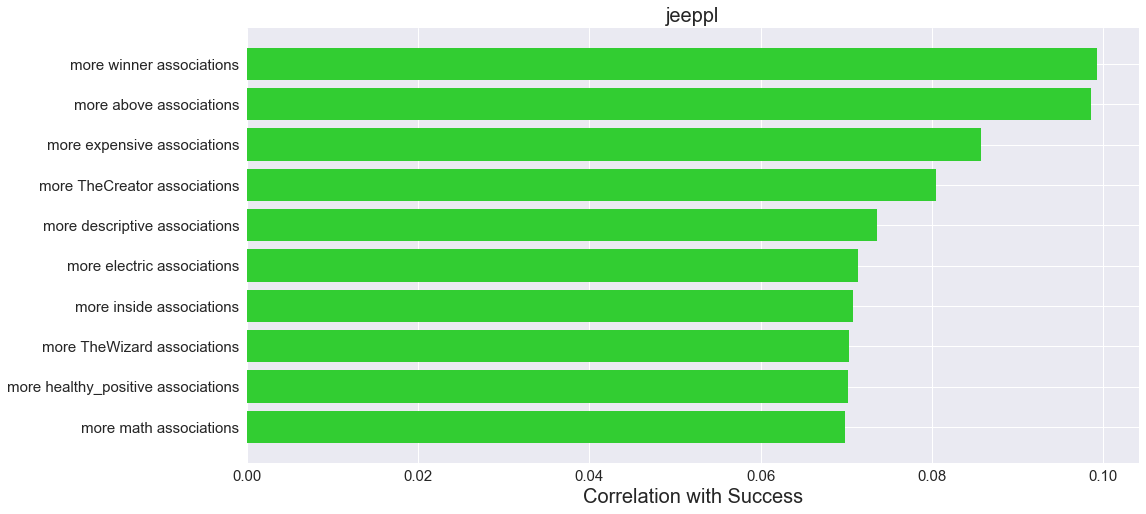

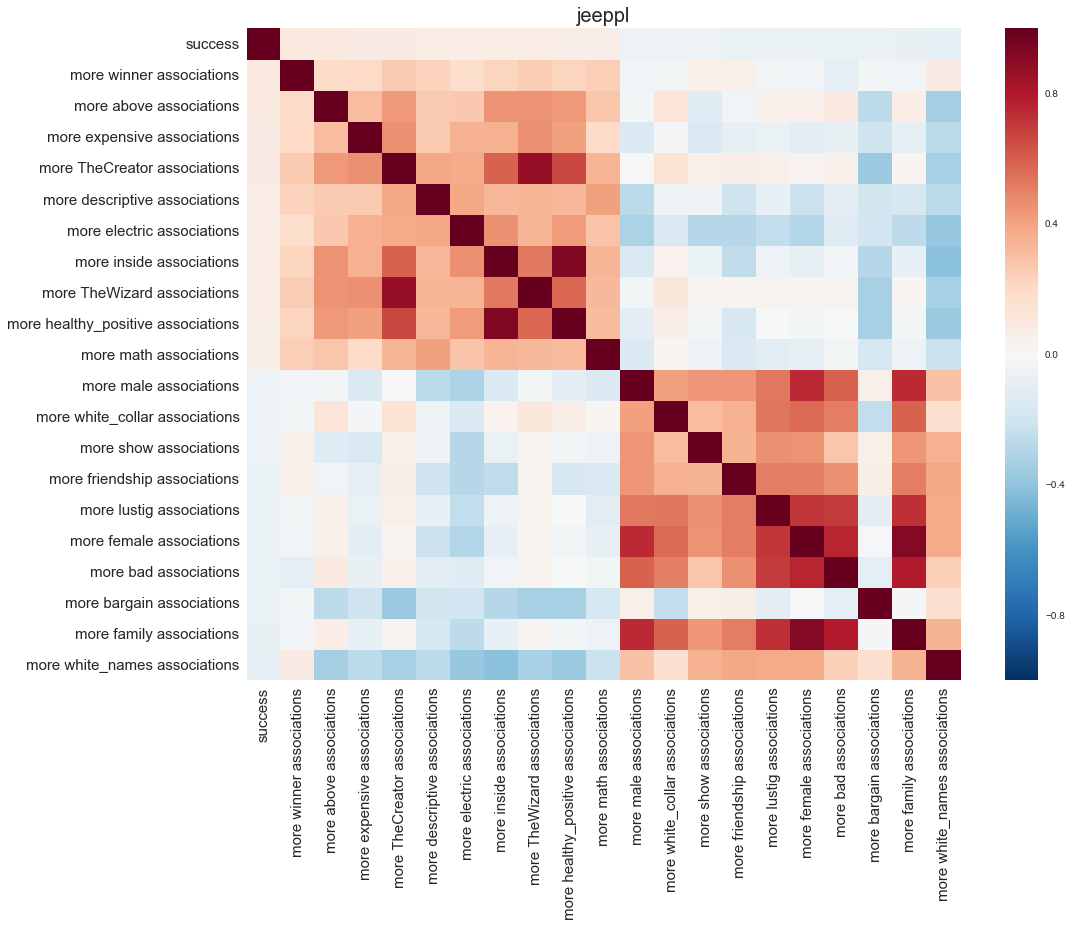

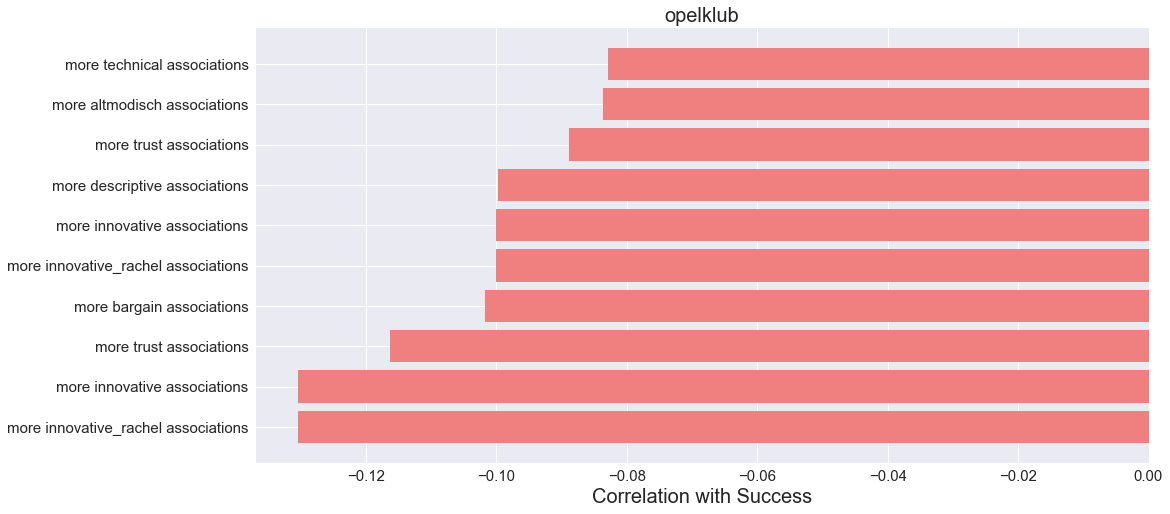

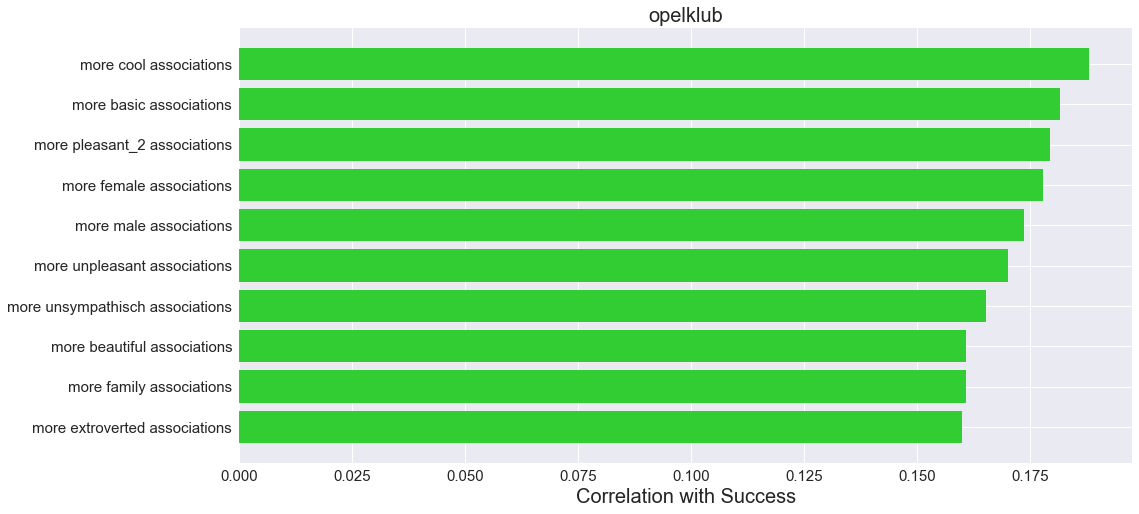

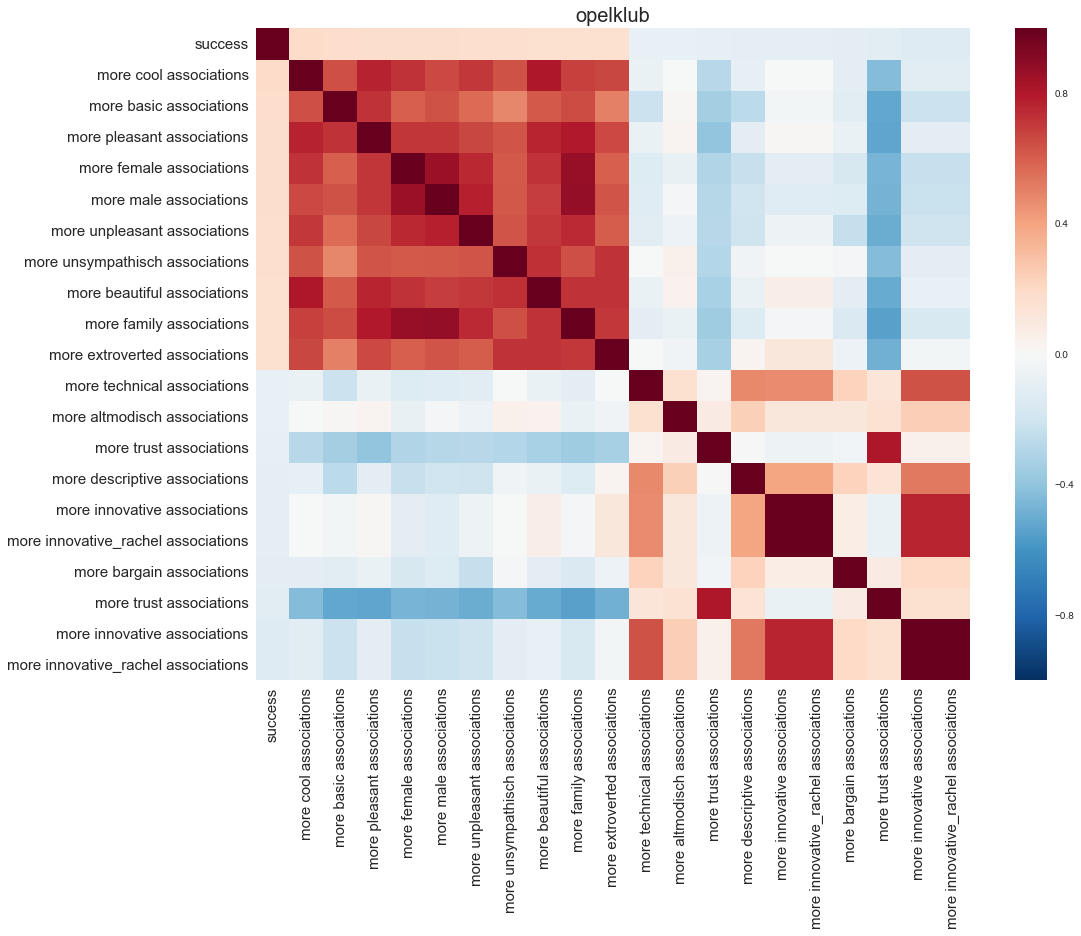

In [104]:
for file, filename in zip(files, filenames):
    try:
        print("doing {}".format(filename))
        pl = preprocess_csv(file)
        feats = get_similarity_features(pl, dimensions)
        get_top_bot(feats, filename)
    except:
        print("error encountered in {}".format(filename))
        continue

# Inter-Brand Comparisons

In [47]:
corr_files = ['data/brands/' + x for x in os.listdir('data/brands') if x.endswith('.csv')]
corr_filenames = [x[x.find('/')+20: x.find('.csv')] for x in corr_files]

In [48]:
corr_filenames

['kiamotorspolska',
 'ferrarikatowice',
 'fiatpl',
 'mercedesbenzpolska',
 'landroverpolska',
 'seatpolska',
 'bmw.polska',
 'jeeppl',
 'lexuspolska',
 'jaguarpolska',
 'toyotapolska',
 'hondapolska',
 'citroenpolska',
 'opelklub',
 'volkswagenpolska',
 'porschepl',
 'skodapolska',
 'chevroletpl',
 'peugeotpolska',
 'renaultpolska',
 'audipl',
 'ford.polska',
 'hyundaipolska']

In [30]:
corr_filenames

['hondapolska',
 'chevroletpl',
 'bmw.polska',
 'seatpolska',
 'skodapolska',
 'fiatpl',
 'ford.polska',
 'kiamotorspolska',
 'mercedesbenzpolska',
 'lexuspolska',
 'landroverpolska',
 'jaguarpolska',
 'toyotapolska',
 'ferrarikatowice',
 'chryslerpolska',
 'audipl',
 'porschepl',
 'citroenpolska',
 'volkswagenpolska',
 'peugeotpolska',
 'renaultpolska',
 'hyundaipolska',
 'jeeppl',
 'opelklub']

In [187]:
def plot_wordclouds(i, thres):
    data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')
    top = data.columns[2:12]
    bottom = data.columns[12:]
    
    plt.figure(figsize=(15,10))

    top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
    bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]

    plt.subplot(121)
    plt.axis("off");
    if len(top_words) != 0:
        print(' '.join(top_words))
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70, stopwords = []).generate('healthy untrustworthy unwirksam impractical dead above below ugly bad cruel')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Positively Correlated\n{} (>{})\n'.format(corr_filenames[i], str(thres)), size=25, )

    plt.subplot(122)
    plt.axis('off')
    if len(bot_words) != 0:
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70, stopwords = []).generate(' '.join([x.split()[1] for x in data.index[data['success']<-thres][1:]]))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Negatively Correlated \n{} (<-{})\n'.format(corr_filenames[i], str(thres)), size=25, )

    plt.savefig('fig/brands/wordclouds_{}.png'.format(corr_filenames[i]), bbox_inches = 'tight')
    plt.clf()

In [188]:
corr_filenames[18]

'peugeotpolska'

In [189]:
for i in [18]:#range(len(corr_filenames)):
    try:
        print(corr_filenames[i])
        plot_wordclouds(i, .1)
    except:
        continue

peugeotpolska
healthy_positive untrustworthy unwirksam impractical dead above below ugly bad cruel


In [66]:
x = pd.read_csv('data/brands/correlogram_volkswagenpolska.csv')['success']

In [246]:
x

0     1.000000
1     0.097237
2     0.080989
3     0.080989
4     0.077836
5     0.077548
6     0.072935
7     0.072511
8     0.071795
9     0.069636
10    0.066334
11   -0.061847
12   -0.063914
13   -0.064337
14   -0.065005
15   -0.065901
16   -0.065945
17   -0.070508
18   -0.074482
19   -0.080065
20   -0.086277
Name: success, dtype: float64

In [56]:
i=-9
thres=.1

In [122]:
def plot_wordclouds(i, count, thres, top_words, bot_words, fig):

    ax1 = fig.add_subplot(19, 2, count)
    ax1.axis("off");
    if len(top_words) != 0:
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70).generate(' '.join(top_words))
        print(corr_filenames[i], ' '.join(top_words))
        ax1.imshow(wordcloud, interpolation='bilinear')
        ax1.set_title('\n{}\nPOS\n'.format(corr_filenames[i], str(thres)), size=42, fontweight='bold')

    ax2 = fig.add_subplot(19, 2, count+1)
    ax2.axis('off')
    if len(bot_words) != 0:
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70).generate(' '.join([x.split()[1] for x in data.index[data['success']<-thres][1:]]))
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.set_title('\n{}\nNEG\n'.format(corr_filenames[i], str(thres)), size=42, fontweight='bold')

#     plt.savefig('fig/brands/wordclouds_{}.png'.format(corr_filenames[i]), bbox_inches = 'tight')

kiamotorspolska math TheCitizen evaluating impractical TheJester above unwirksam extrovert TheCarer math
ferrarikatowice altmodisch traditionell small expensive bargain cold unappetitlich healthy_positive
fiatpl traditional blue_collar innovative_rachel innovative technical african_names TheHero TheRuler altmodisch inside
mercedesbenzpolska african_names african_names white_names altmodisch volkswagen european_names trust musical_instrument
seatpolska power trust neurotic TheRuler community power lifestyle inaktiv career innovative
bmw.polska african_names african_names musical_instrument lustig volkswagen altmodisch european_names music ugly unsympathisch
lexuspolska unattractive cool TheRebel ugly open appetitlich warm unappetitlich pleasant lifestyle
jaguarpolska valuable TheCreator TheRuler TheWizard TheExplorer teaching TheCarer evaluating community fascination
toyotapolska traditionell untrustworthy above bad closed unpleasant TheCitizen dead uncool small
hondapolska innovative i

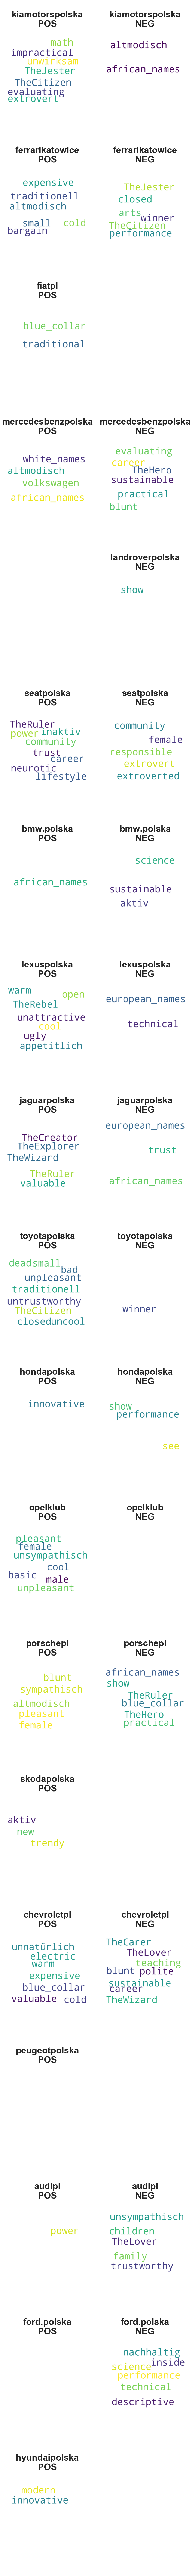

In [123]:
fig = plt.figure(figsize=(15,220))

count = 1
for i in range(len(corr_filenames)):
    data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')
    top = data.columns[2:12]
    bottom = data.columns[12:]
    top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
    bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]
    if (len(top_words) != 0) or (len(bot_words) != 0):
        plot_wordclouds(i, count, .1, top_words, bot_words, fig)
        count += 2
plt.savefig('fig/brands/wordclouds_ALL.png', bbox_inches = 'tight')


In [114]:
corr_files[-5]

'data/brands/correlogram_peugeotpolska.csv'

In [115]:
data = pd.read_csv(corr_files[-5], index_col='Unnamed: 0')
top = data.columns[2:12]
bottom = data.columns[12:]


In [118]:
bottom

Index(['more sympathisch associations', 'more bad associations.1',
       'more appetitlich associations', 'more new associations',
       'more african_names associations', 'more trust associations',
       'more blue_collar associations', 'more african_names associations.1',
       'more trust associations.1'],
      dtype='object')

In [119]:
    top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
    bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]


In [121]:
bot_words

[]